In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from skimage import io, data, color
import re
from re import findall,UNICODE

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.linear_model import LogisticRegressionCV as logregcv
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from scipy.stats import ttest_ind as ttest
from scipy.stats import ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests

from labMTsimple.speedy import *
from bgfunc import *

import warnings
warnings.filterwarnings("ignore")


/Users/andrew/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Load SQLite database 

In [2]:
dbfile = 'project_apr11_1238pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
med = 'ig'
condition = 'depression'
test_name = 'cesd'
test_cutoff = 21
photos_rated = True
has_test = True
gb_types = ['url','username','created_date']
periods = ['before','after']
turn_points = ['from_diag','from_susp']

In [4]:
params = define_params(condition, test_name, test_cutoff, photos_rated, has_test)

In [5]:
data = make_data_dict(params, condition, test_name, conn)

## Sample sizes across all conditions

In [6]:
#report_sample_sizes(params, conn)

## Instagram Analysis

## Find out how many individuals are represented in correct vs incorrect predictions
Eg. do we get some users who always show up in false neg or false pos, or in true pos?  
This might be especially useful for the url and created date analyses, where we don't know the extent to which a subset of usernames might be driving correct classification.  
for those in false pos, look at the actual posts (might be easier for twitter), and maybe even have mturk rate whether they seem depressed or not. are we finding new depressed cases, or are we just wrong?  

## Restrict username analysis to only those individuals with a minimum number of days represented in their observations 
Alternately, min number of posts   
See R code notes for more. (bayes.R)

## Move R code to Jupyter?

In [7]:
do_print = False # for notebook-format report printout of exploratory/data cleaning functions

In [8]:
# collect target and control data
for pop, pop_long in [('t','target'),('c','control')]:
    
    # get hsv data
    get_hsv(data, med, params, conn, pop, pop_long)
    
    # this if- block deals with conditions where photos have been rated
    if params['rated']: 
        
        kind = 'ratings'
        
        d = get_photo_ratings(params, conn, pop)

        # print 'Indices with broken photos:', find_and_drop_broken_photos(d, drop_from_df=False)
        find_and_drop_broken_photos(d) # this call actually drops them

        d2 = get_meta_ig(params, conn, pop)

        # Now merge the meta_ig data with the photo_ratings_depression data
        consolidate_data(d, d2, med, pop_long, kind, data)
        
        if do_print:
            # Hunting for ratings errors
            print_coltype(data, condition, med, pop)
            ixs = find_chartype(data,'interesting')

        ''' Warning: This isn't very robust - you have this conditional set here because you discovered it's only the 
            target group photo ratings that have the problematic "strings for photo ratings" issue.  

            A more generalized way to go about this would be to create a flag from find_chartype() that identifies whether 
            map_str_ratings_to_numeric() is necessary...but even then, the custom mapping you created is really case specific 
            and does not easily generalize. 
            
            It's probably not worth trying to generalize these functions for the purposes of your dissertation research. '''

        if pop_long == 'target':
            map_str_ratings_to_numeric(data) 

        if do_print:
            # Check fixed ratings 
            print_coltype(data, condition, med, pop=pop)

        # And now merge ratings data with hsv data
        consolidate_data(data[med][pop_long][kind], data[med][pop_long]['hsv'], med, pop_long, 'all', data)
    
    
    # aggregate data by groupby types (url, username, created_date)
    make_groupby(data[med][pop_long], med, pop_long, params, gb_types)
    

    if pop_long == 'target':
        # creates before/after subsets for target pop
        # subsets stored in: data[m]['target'][period][turn_point]['all']
        make_timeline_subsets(data, med, periods)
    
        for period in periods:
            for turn_point in turn_points:
                # aggregate data by groupby types (url, username, created_date)
                make_groupby(data[med][pop_long][period][turn_point], med, pop_long, params, gb_types,
                             period = period, turn_point=turn_point)

Shape of consolidated TARGET RATINGS data: (22860, 16)
Shape of consolidated TARGET ALL data: (22860, 19)
Subset shape for IG BEFORE FROM_DIAG: (12643, 19)
Subset shape for IG BEFORE FROM_SUSP: (2539, 19)
Subset shape for IG AFTER FROM_DIAG: (10217, 19)
Subset shape for IG AFTER FROM_SUSP: (4410, 19)

Shape of consolidated CONTROL RATINGS data: (22338, 16)
Shape of consolidated CONTROL ALL data: (22338, 19)


In [9]:
save_to_file = False # to save locally to csv
density = True # to plot target vs control per-variable densities
ml = False # to run machine learning models
nhst = True # for NHST t-tests


Merge to master: MAIN url
target vs control for IG URL-groupby:


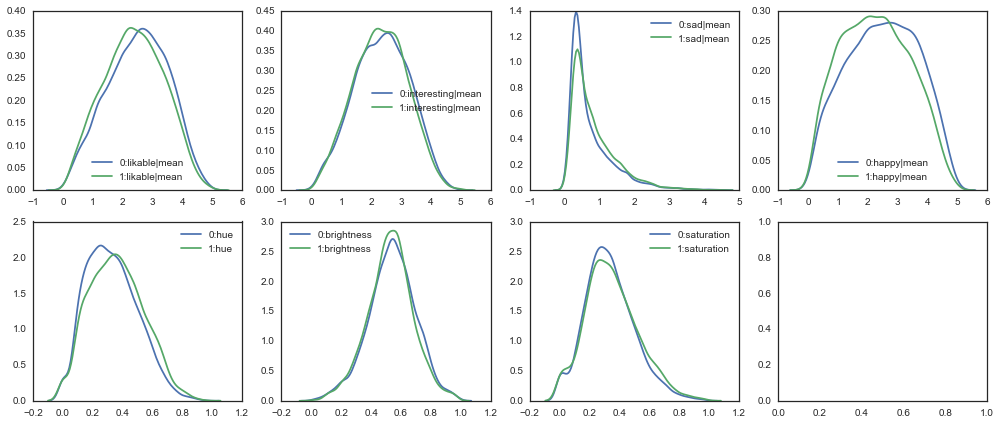

Correlation matrix:


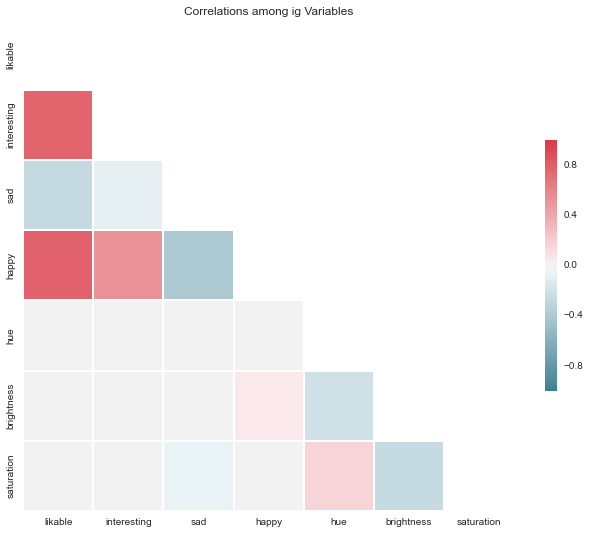

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.77 -0.27   0.78 -0.00        0.03       -0.01
interesting     0.77         1.00 -0.08   0.52 -0.01        0.02       -0.02
sad            -0.27        -0.08  1.00  -0.40 -0.02       -0.03       -0.07
happy           0.78         0.52 -0.40   1.00  0.01        0.05        0.02
hue            -0.00        -0.01 -0.02   0.01  1.00       -0.21        0.16
brightness      0.03         0.02 -0.03   0.05 -0.21        1.00       -0.26
saturation     -0.01        -0.02 -0.07   0.02  0.16       -0.26        1.00
UNIT OF OBSERVATION: URL
NAIVE ACCURACY ALL NULL: 0.555
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN url):
NAIVE ACCURACY: 0.554

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control          1257          937
known_target            829          933

Proportion of pred_ta

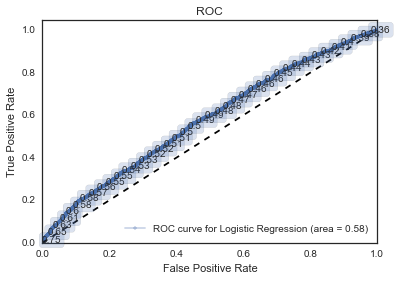

MODEL: Random Forests target (Models: MAIN url):
NAIVE ACCURACY: 0.574

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1433          761
known_target            926          836

Proportion of pred_target in known_control: 0.347
Proportion of pred_target in known_target: 0.474




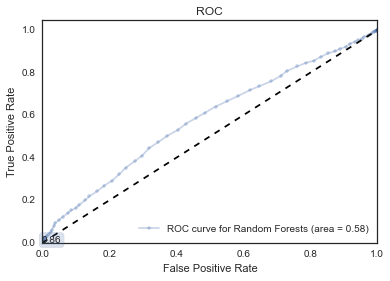

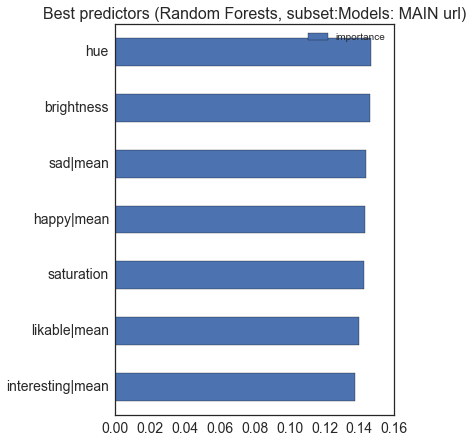

MODEL: Support Vector Machine target (Models: MAIN url):
NAIVE ACCURACY: 0.556

CONFUSION MATRIX (svc):
               pred_control  pred_target
known_control          1260          934
known_target            824          938

Proportion of pred_target in known_control: 0.426
Proportion of pred_target in known_target: 0.532




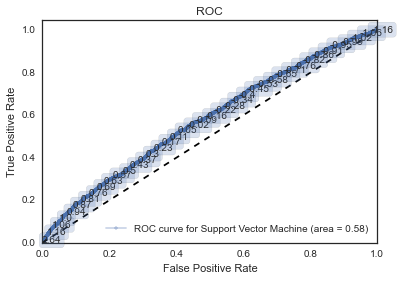


Merge to master: MAIN username
target vs control for IG USERNAME-groupby:


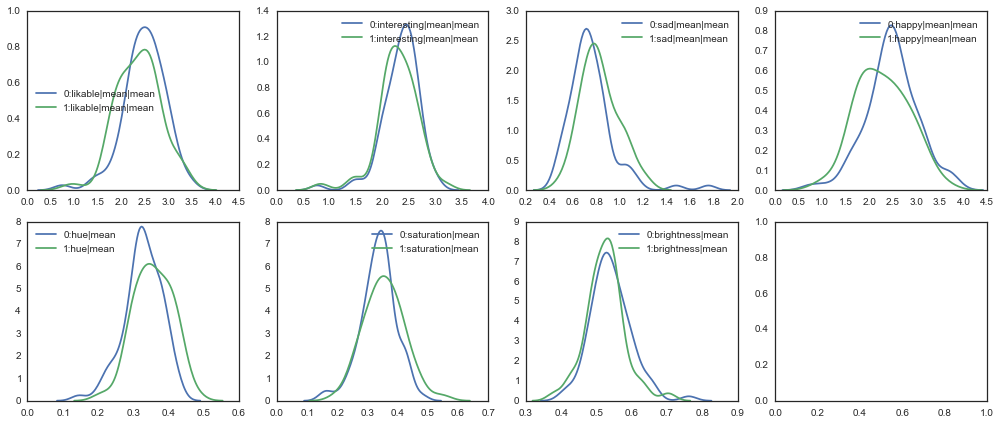

Correlation matrix:


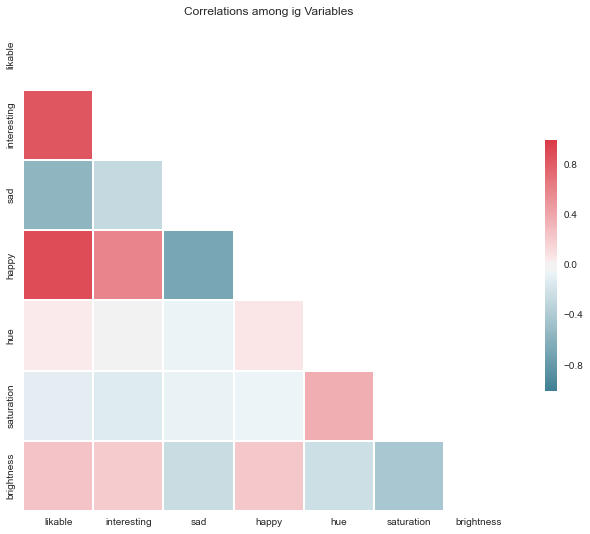

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.85 -0.56   0.90  0.04       -0.10        0.25
interesting     0.85         1.00 -0.27   0.60 -0.01       -0.12        0.21
sad            -0.56        -0.27  1.00  -0.68 -0.06       -0.07       -0.25
happy           0.90         0.60 -0.68   1.00  0.07       -0.05        0.23
hue             0.04        -0.01 -0.06   0.07  1.00        0.37       -0.22
saturation     -0.10        -0.12 -0.07  -0.05  0.37        1.00       -0.42
brightness      0.25         0.21 -0.25   0.23 -0.22       -0.42        1.00
UNIT OF OBSERVATION: USERNAME
NAIVE ACCURACY ALL NULL: 0.625
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN username):
NAIVE ACCURACY: 0.6

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control            14           11
known_target              5           10

Proportion of

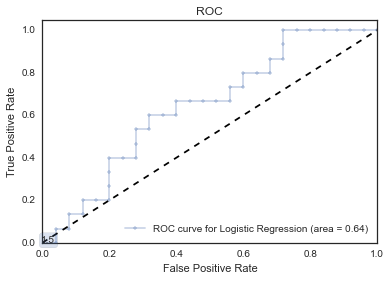

MODEL: Random Forests target (Models: MAIN username):
NAIVE ACCURACY: 0.625

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control            18            7
known_target              8            7

Proportion of pred_target in known_control: 0.28
Proportion of pred_target in known_target: 0.467




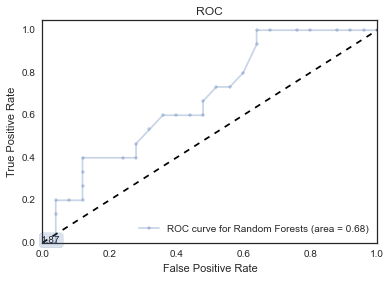

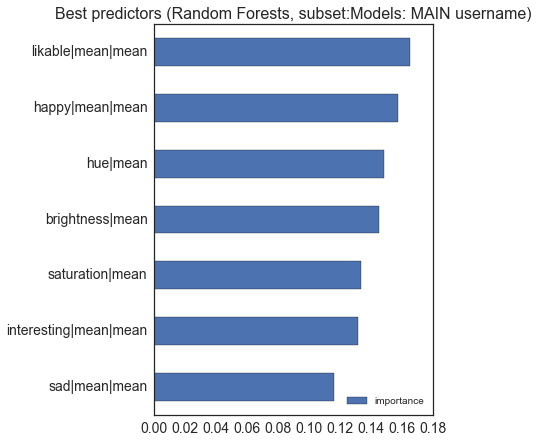

MODEL: Support Vector Machine target (Models: MAIN username):
NAIVE ACCURACY: 0.625

CONFUSION MATRIX (svc):
               pred_control  pred_target
known_control            17            8
known_target              7            8

Proportion of pred_target in known_control: 0.32
Proportion of pred_target in known_target: 0.533




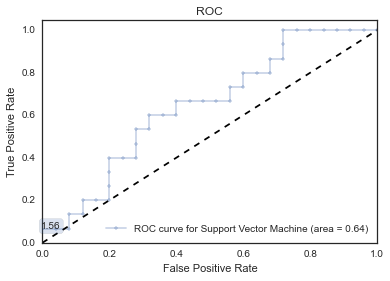


Merge to master: MAIN created_date
target vs control for IG CREATED_DATE-groupby:


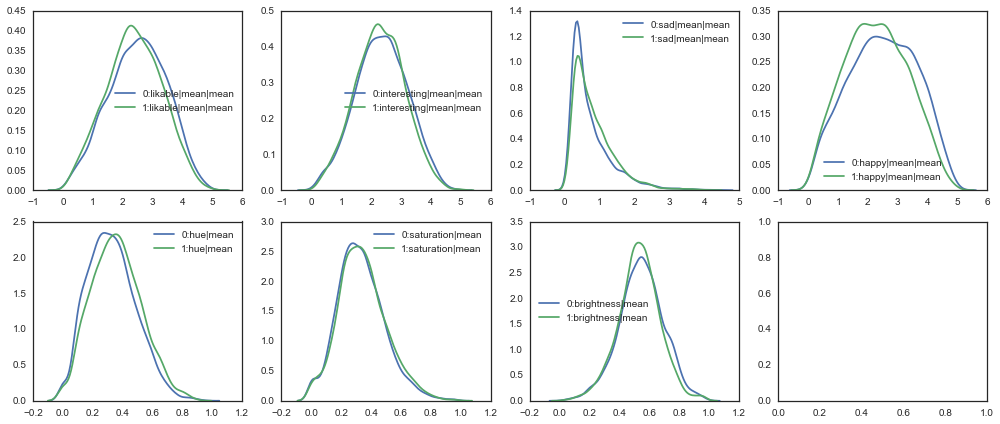

Correlation matrix:


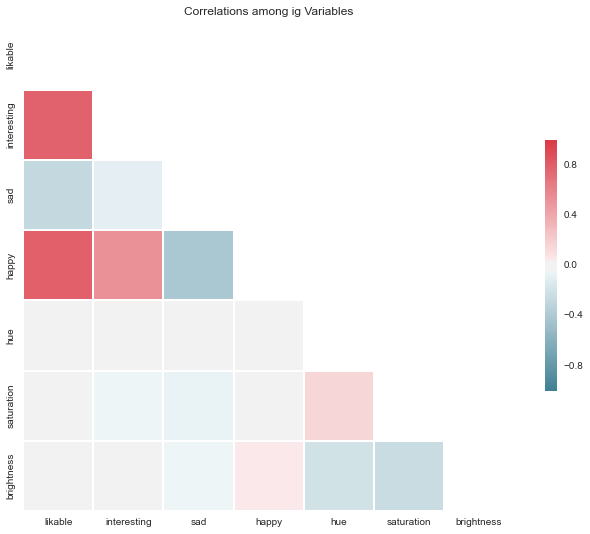

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.28   0.79 -0.00       -0.02        0.03
interesting     0.78         1.00 -0.09   0.53 -0.03       -0.04        0.03
sad            -0.28        -0.09  1.00  -0.41 -0.02       -0.07       -0.04
happy           0.79         0.53 -0.41   1.00  0.02        0.02        0.05
hue            -0.00        -0.03 -0.02   0.02  1.00        0.15       -0.20
saturation     -0.02        -0.04 -0.07   0.02  0.15        1.00       -0.25
brightness      0.03         0.03 -0.04   0.05 -0.20       -0.25        1.00
UNIT OF OBSERVATION: CREATED_DATE
NAIVE ACCURACY ALL NULL: 0.565
  *'ALL NULL' means if all observations are predicted as uncompleted assessments


MODEL: Logistic Regression target (Models: MAIN created_date):
NAIVE ACCURACY: 0.564

CONFUSION MATRIX (lr):
               pred_control  pred_target
known_control           891          631
known_target            543          628

Pro

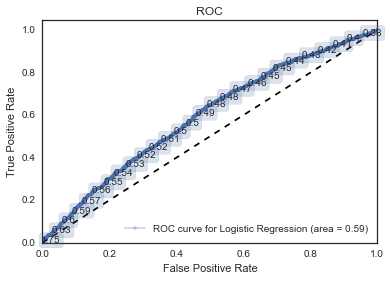

MODEL: Random Forests target (Models: MAIN created_date):
NAIVE ACCURACY: 0.567

CONFUSION MATRIX (rf):
               pred_control  pred_target
known_control          1103          419
known_target            747          424

Proportion of pred_target in known_control: 0.275
Proportion of pred_target in known_target: 0.362




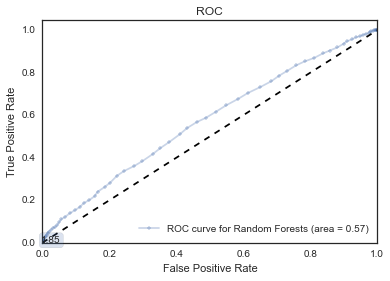

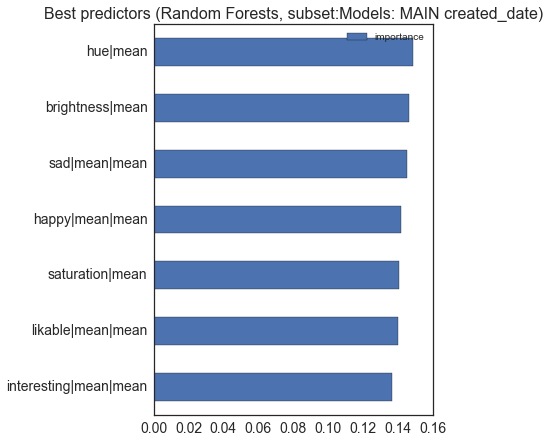

MODEL: Support Vector Machine target (Models: MAIN created_date):
NAIVE ACCURACY: 0.568

CONFUSION MATRIX (svc):
               pred_control  pred_target
known_control           888          634
known_target            529          642

Proportion of pred_target in known_control: 0.417
Proportion of pred_target in known_target: 0.548




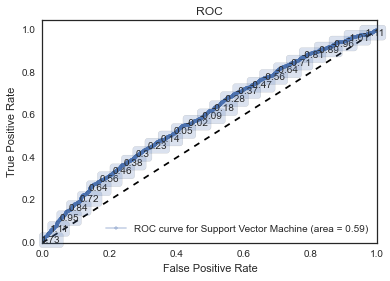

In [10]:
master = data[med]['master']
target = data[med]['target']['gb']
control = data[med]['control']['gb'] 
m = med
report = 'MAIN'

master_actions(master, target, control, condition,
               m, params, gb_types, report,
               save_to_file = False, density = True, corr = True, ml = True, nhst = False)


Merge to master: before from_diag url
target vs control for IG URL-groupby:


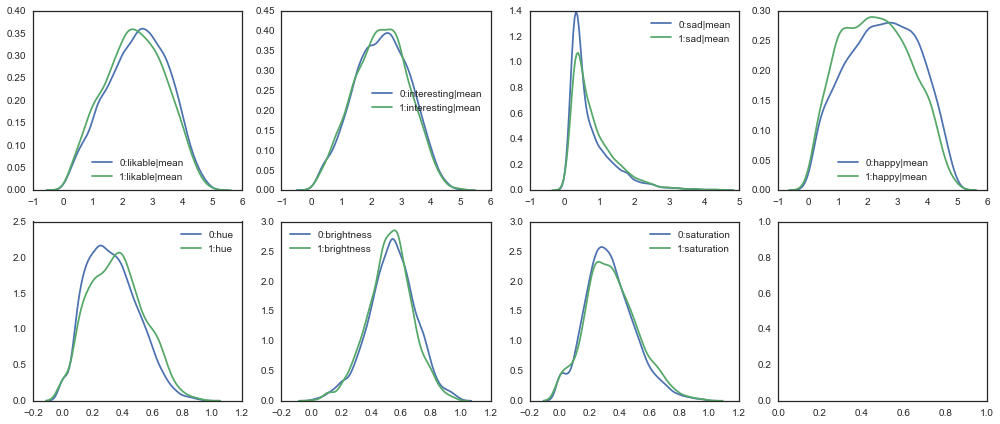


Merge to master: before from_diag username
target vs control for IG USERNAME-groupby:


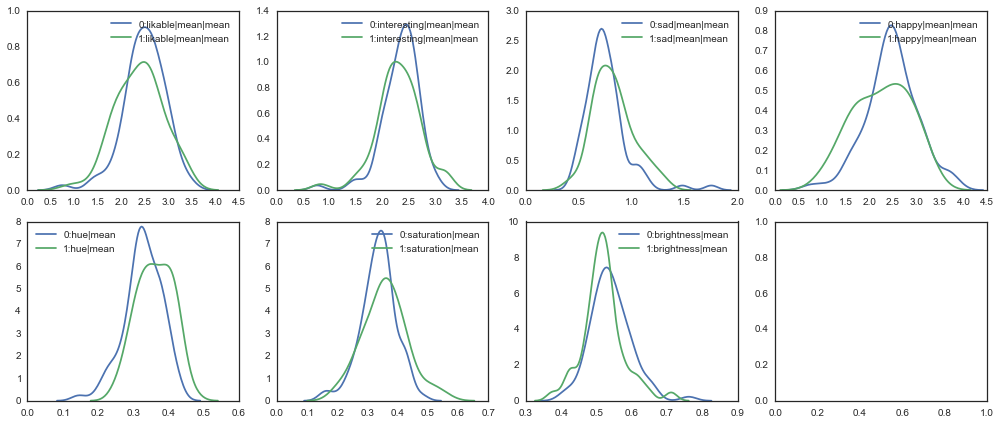


Merge to master: before from_diag created_date
target vs control for IG CREATED_DATE-groupby:


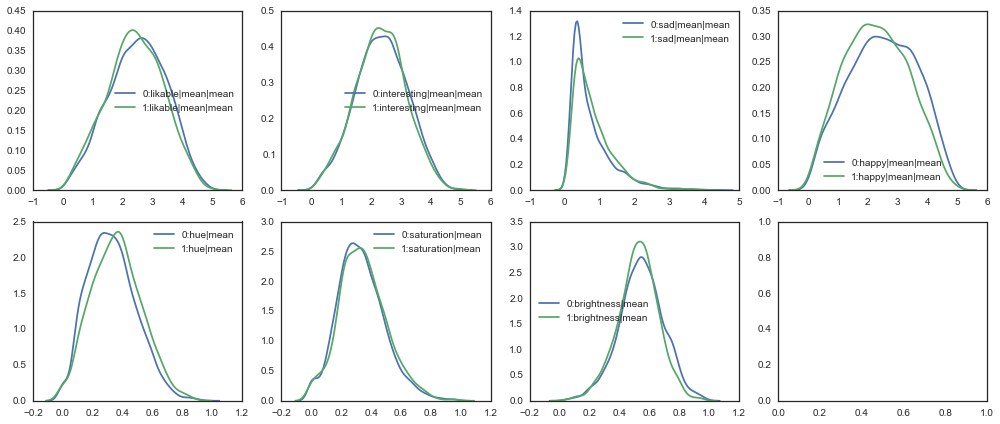


Merge to master: before from_susp url
target vs control for IG URL-groupby:


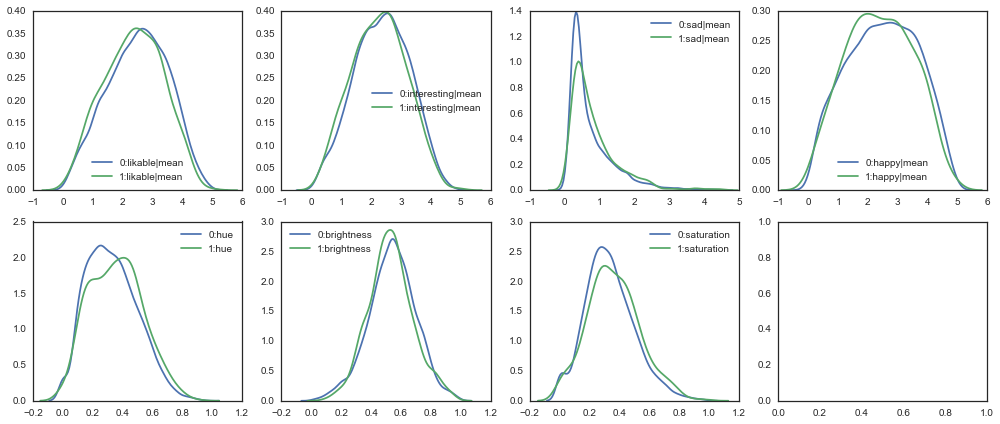


Merge to master: before from_susp username
target vs control for IG USERNAME-groupby:


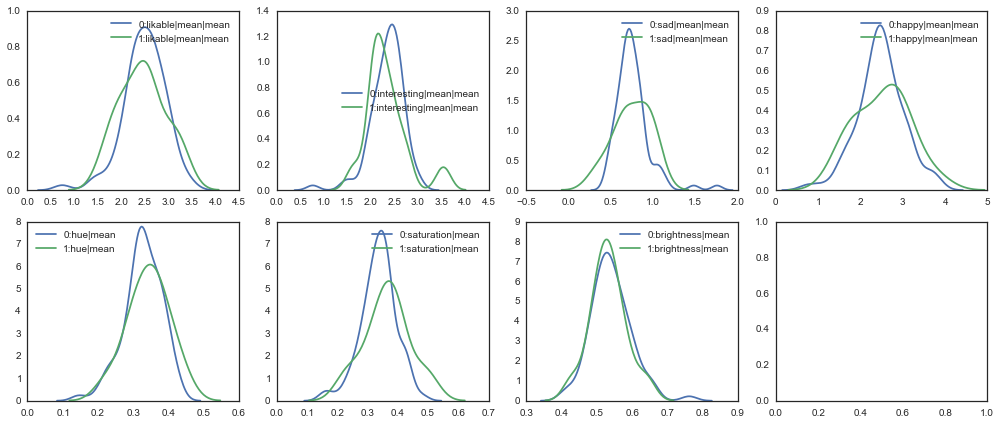


Merge to master: before from_susp created_date
target vs control for IG CREATED_DATE-groupby:


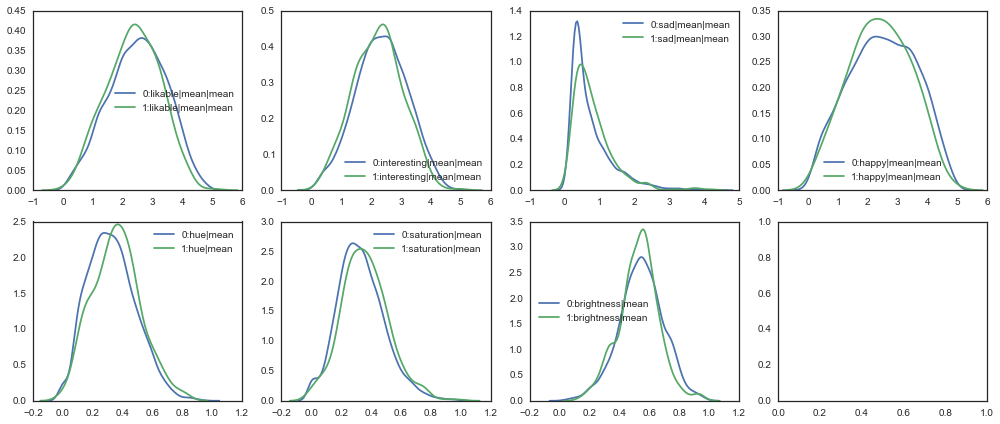


Merge to master: after from_diag url
target vs control for IG URL-groupby:


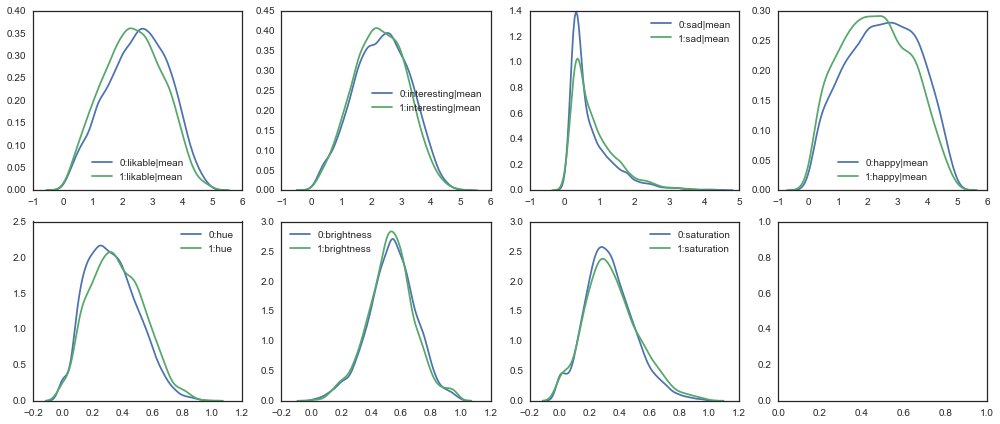


Merge to master: after from_diag username
target vs control for IG USERNAME-groupby:


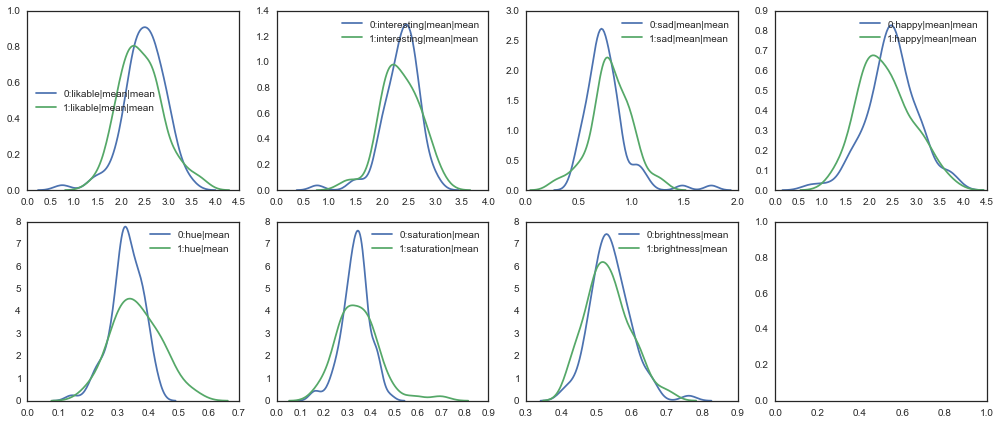


Merge to master: after from_diag created_date
target vs control for IG CREATED_DATE-groupby:


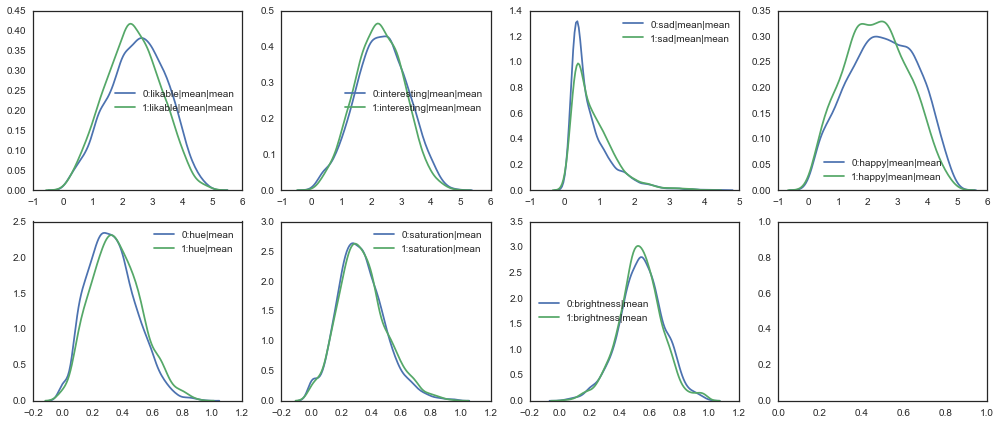


Merge to master: after from_susp url
target vs control for IG URL-groupby:


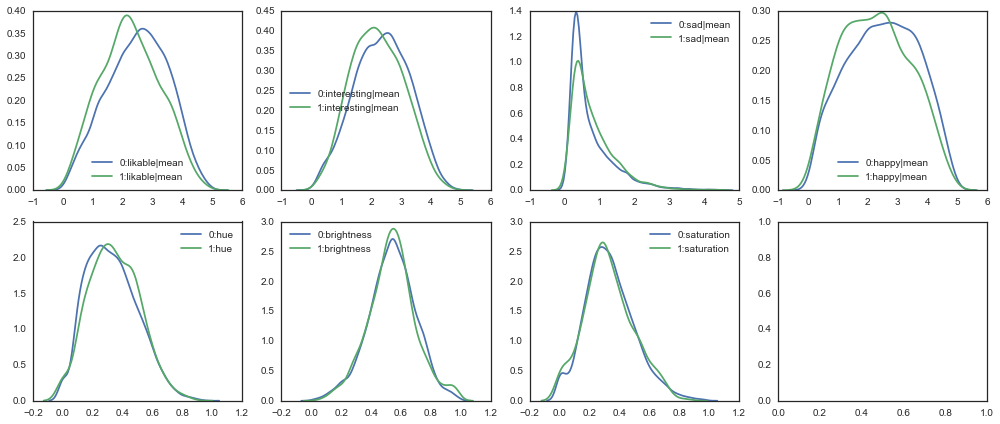


Merge to master: after from_susp username
target vs control for IG USERNAME-groupby:


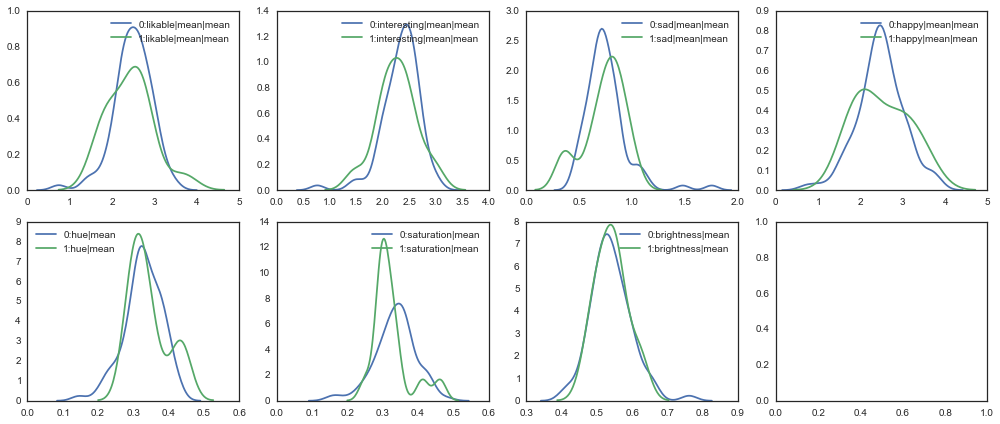


Merge to master: after from_susp created_date
target vs control for IG CREATED_DATE-groupby:


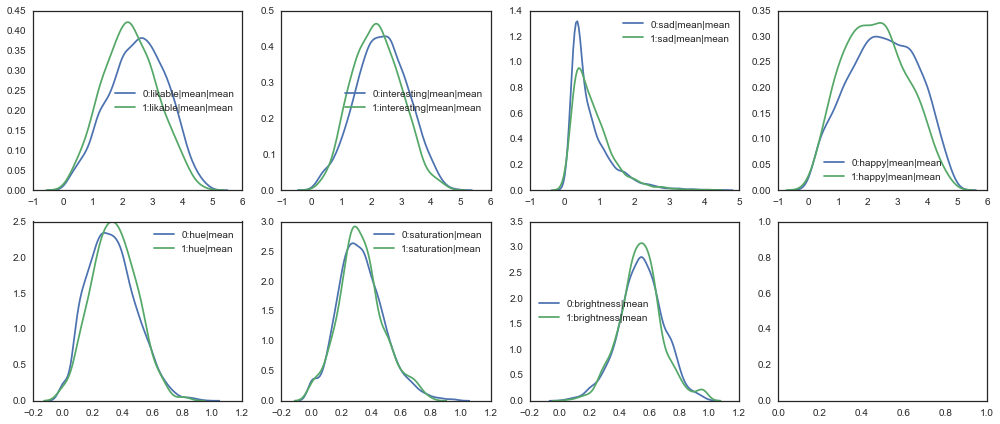

In [11]:
for period in periods:
    for turn_point in turn_points:    
        
        data[med]['master'][period] = {turn_point:{}}
        master = data[med]['master'][period][turn_point]
        target = data[med]['target'][period][turn_point]['gb']
        control = data[med]['control']['gb'] 
        m = med
        report = '{} {}'.format(period,turn_point)
        
        # merge target, control, into master
        master_actions(master, target, control, condition,
                       med, params, gb_types, report,
                       save_to_file = False, density = True, corr = False, ml = False, nhst = False)

### Within-target before vs after


before vs after (target: depression) for url-groupby, based on diag_date:


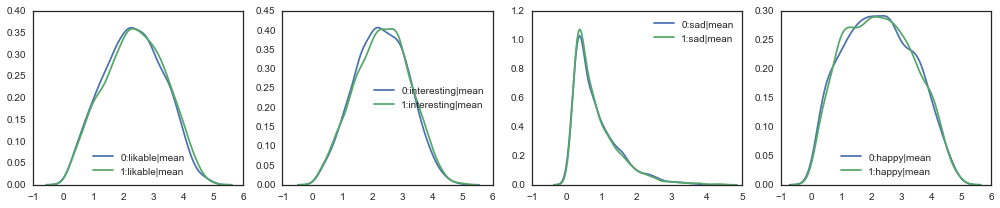

UNIT OF MEASUREMENT: url

RATING: likable|mean
Ttest_indResult(statistic=-2.3845061717528013, pvalue=0.017132549604376403)

RATING: interesting|mean
Ttest_indResult(statistic=-1.6032928474066477, pvalue=0.10892197503979012)

RATING: sad|mean
Ttest_indResult(statistic=0.33399965114671565, pvalue=0.73839134484097035)

RATING: happy|mean
Ttest_indResult(statistic=-0.3749914074260835, pvalue=0.70767994091853748)

RATING: hue
Ttest_indResult(statistic=-0.067749404231186514, pvalue=0.94598734921253658)

RATING: brightness
Ttest_indResult(statistic=1.6702961689778846, pvalue=0.094912270165949233)

RATING: saturation
Ttest_indResult(statistic=0.16741195478834087, pvalue=0.8670514888472145)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (0.119927847231)
interesting|mean significant post-correction? False (0.762453825279)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? False (1.0)
hue significant pos

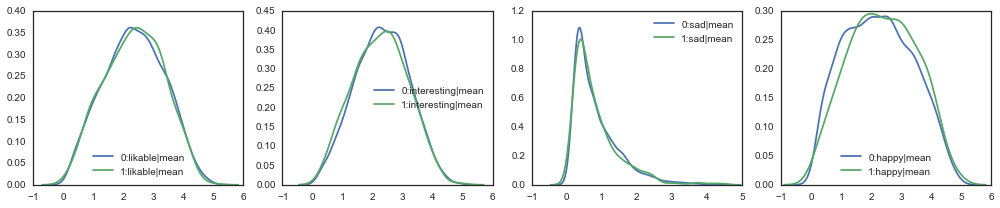

UNIT OF MEASUREMENT: url

RATING: likable|mean
Ttest_indResult(statistic=0.2396082706171257, pvalue=0.81064203209610808)

RATING: interesting|mean
Ttest_indResult(statistic=1.613730427154149, pvalue=0.1066378224999512)

RATING: sad|mean
Ttest_indResult(statistic=0.1506459671140325, pvalue=0.88025999766374086)

RATING: happy|mean
Ttest_indResult(statistic=-3.1019283278837926, pvalue=0.0019314580772957961)

RATING: hue
Ttest_indResult(statistic=0.62472133512491679, pvalue=0.53217741811483588)

RATING: brightness
Ttest_indResult(statistic=-0.32361977394501212, pvalue=0.74623704971196392)

RATING: saturation
Ttest_indResult(statistic=-1.7552373844000857, pvalue=0.07926908608925641)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (1.0)
interesting|mean significant post-correction? False (0.7464647575)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? True (0.0135202065411)
hue significant post-corr

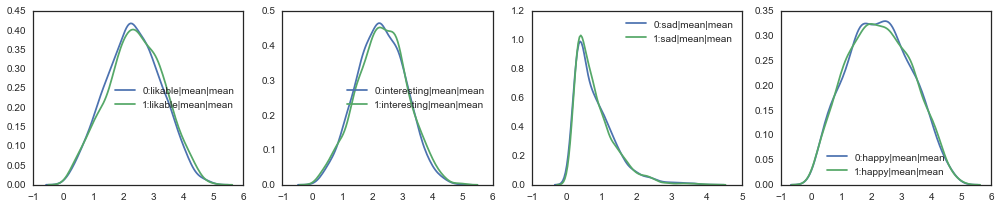

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=-2.3188694021164298, pvalue=0.020453082534706592)

RATING: interesting|mean|mean
Ttest_indResult(statistic=-1.6326568052757053, pvalue=0.10262118556420838)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.55932119822664805, pvalue=0.57597435412714637)

RATING: happy|mean|mean
Ttest_indResult(statistic=-0.19975356002222983, pvalue=0.84168364186603117)

RATING: hue|mean
Ttest_indResult(statistic=-0.43788872941441936, pvalue=0.66149097419298775)

RATING: saturation|mean
Ttest_indResult(statistic=-0.60666603835743049, pvalue=0.54410755417637002)

RATING: brightness|mean
Ttest_indResult(statistic=3.1696882380623084, pvalue=0.0015377307338428159)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (0.143171577743)
interesting|mean|mean significant post-correction? False (0.718348298949)
sad|mean|mean significant post-correction? False (1.0)
happy|mea

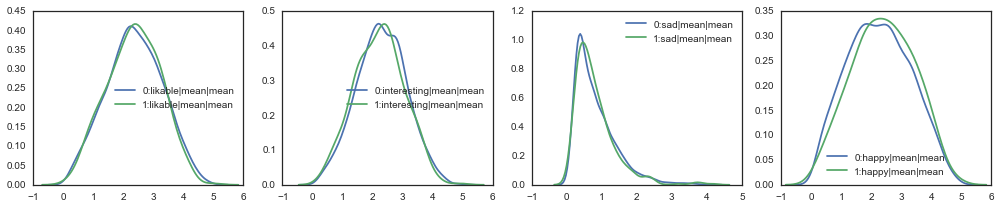

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=0.43151700182544678, pvalue=0.66611612682497356)

RATING: interesting|mean|mean
Ttest_indResult(statistic=1.8343905297713923, pvalue=0.066671487191537981)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.64062954244758641, pvalue=0.5218006947778876)

RATING: happy|mean|mean
Ttest_indResult(statistic=-2.5100748275033298, pvalue=0.012110369498700537)

RATING: hue|mean
Ttest_indResult(statistic=0.0088715905446251232, pvalue=0.99292203732959461)

RATING: saturation|mean
Ttest_indResult(statistic=-2.1536569736378262, pvalue=0.031327625737142366)

RATING: brightness|mean
Ttest_indResult(statistic=0.4221621183861865, pvalue=0.67292974722116217)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (0.466700410341)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean signifi

In [12]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['url','created_date']: 
    before_vs_after(data[med]['target']['gb'], gb_type, condition, params)

## Twitter

In [524]:
tw = {}

In [707]:
# get tweets from depressed population (above cesd threahold)
q = 'select username, {test} from {cond} where {test} >= {cutoff} and platform="twitter" and disqualified=0'.format(test=test_name,cutoff=test_cutoff,cond=condition)
print q
print
test_ok = pd.read_sql_query(q,conn)
print 'Number of depression samples above cutoff {}={}:'.format(test_name,test_cutoff), test_ok.shape[0]
print 
print

q = 'select username, twitter_user_id as uid, created_date, has_url, text, d_from_diag_{cond} as from_diag, d_from_susp_{cond} as from_susp from meta_tw where d_from_diag_{cond} is not null'.format(cond=condition)
print q
print
tw['target'] = pd.read_sql_query(q,conn,parse_dates=['created_date'])
tw['target'][condition] = 1
print 'Total target population tweets:', tw['target'].shape[0]

select username, cesd from depression where cesd >= 22 and platform="twitter" and disqualified=0

Number of depression samples above cutoff cesd=22: 114


select username, twitter_user_id as uid, created_date, has_url, text, d_from_diag_depression as from_diag, d_from_susp_depression as from_susp from meta_tw where d_from_diag_depression is not null

Total target population tweets: 213534


In [708]:
testok_uids = tw['target'].ix[tw['target'].username.isin(test_ok.username),:].uid.unique()

In [712]:
test_ok.groupby('username').count().shape

(114, 1)

In [721]:
unames = "'" + "','".join(test_ok.username) + "'"
a = pd.read_sql_query('select username, medium, total_posts, collect_error, collected, valid_depression from usernames where medium="twitter" and username in ({})'.format(unames),conn)

In [723]:
pd.read_sql_query('select count(*) from meta_tw where username="MandyLouiseD"', conn)

count(*)
0      3166

In [739]:
len(testok_uids)

105

In [745]:
diffs = np.setdiff1d(test_ok.username,tw['target'].ix[tw['target'].uid.isin(testok_uids),'username'].unique())

In [746]:
a.ix[a.username.isin(diffs),:]

username   medium  total_posts  \
11         meeganova  twitter        213.0   
61   brittanipouewel  twitter          0.0   
70       josh_hafler  twitter          0.0   
85   rajkuma40488742  twitter          0.0   
93        nictakiego  twitter         22.0   
99     EmmanuelH1217  twitter          0.0   
106   Panhandlegold1  twitter          3.0   
107        revalatia  twitter        368.0   

                                         collect_error  collected  \
11   Twitter API returned a 401 (Unauthorized), Inv...          1   
61                                                              0   
70                                                              0   
85                                    Not enough posts          1   
93                                                              1   
99                                    Not enough posts          0   
106                                   Not enough posts          0   
107                                                             1   

      valid_depression  
11                None  
61   R_1MG7ISGdFsIqd49  
70   R_xgbJeaCYt6YRk9X  
85   R_31sYuJRCbecW71X  
93   R_1K8smPfbb7rImg0  
99   R_eRGk2LJxeLr5QR3  
106  R_2wpOPsbsT2fWKjQ  
107  R_3HNg6URI5NSQTrG

In [732]:
testok_uids[]

/Users/andrew/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
  if __name__ == '__main__':


23188280

In [725]:
print 'Total {} samples:'.format(condition), tw['target'].groupby('username').count().shape[0]
print ('{} samples above {}={} cutoff'.format(condition,test_name,test_cutoff), 
       tw['target'].ix[tw['target'].uid.isin(testok_uids),:].groupby('username').count().shape[0])

Total depression samples: 137
('depression samples above cesd=22 cutoff', 105)


In [528]:
q = 'select username from control where platform="twitter" and {}="No" and username is not null and disqualified =0'.format(condition)
tw_control_names = pd.read_sql_query(q,conn)
print tw_control_names.shape
uname_str = "','".join(tw_control_names.username)

q = "select username, twitter_user_id as uid, retweet_count, favorite_count, created_date, has_url, text from meta_tw where username in ('{}')".format(uname_str)
tw['control'] = pd.read_sql_query(q,conn,parse_dates=['created_date'])
tw['control'][condition] = 0
print tw['control'].shape

(109, 1)
(115733, 8)


In [529]:
tw['master'] = pd.concat([tw['target'], tw['control']])
tw['master'].shape

(329267, 10)

The has_url field apparently didn't get populated a lot.  We can fix it now with some simple regex:

In [530]:
print 'Number of tweets with url in text:', np.sum(tw['master'].has_url==1)
print 'Adding url tags...'
tw['master'].ix[tw['master'].text.str.contains('http:'), 'has_url'] = 1
tw['master'].ix[~tw['master'].text.str.contains('http:'), 'has_url'] = 0
tw['master'].has_url = tw['master'].has_url.astype(int)
print 'Number of tweets with url in text:', np.sum(tw['master'].has_url==1)


Number of tweets with url in text: 0
Adding url tags...
Number of tweets with url in text: 90545


We can also add a 'has_rt' field, checking for number of retweets, and a 'is_reply' field, a la dechoudhury, that looks to see whether there's an @ tag in the tweet

In [684]:
print 'Adding reply tags...'
tw['master']['is_reply'] = 0
tw['master'].ix[tw['master'].text.str.contains('@'), 'is_reply'] = 1
print 'Number of tweets with @ in text:', np.sum(tw['master'].is_reply==1)


Adding reply tags...
Number of tweets with @ in text: 174378


In [685]:
print 'Adding RT tags...'
tw['master']['is_rt'] = 0
tw['master'].ix[tw['master'].text.str.contains('^RT '), 'is_rt'] = 1
print 'Number of tweets with RT:', np.sum(tw['master'].is_rt==1)


Adding RT tags...
Number of tweets with RT: 66725


### Aggregate at the per-person, per-day level

In [694]:
tw['gb_date'] = (tw['master'].groupby(['uid','created_date'])
                             .agg({'username':'count',
                                    condition:'mean',
                                    'has_url':'sum',
                                    'is_rt':'sum',
                                    'is_reply':'sum',
                                    'from_diag':'mean',
                                    'from_susp':'mean',
                                    'text':' '.join}))
tw['daily'] = tw['gb_date'].reset_index()
tw['daily'].rename(columns={'username':'tweet_count'}, inplace=True)
tw['daily'].head(2)

uid created_date  tweet_count  from_susp  is_rt  is_reply  \
0  755651   2007-02-07            4        NaN      0         0   
1  755651   2007-02-08            3        NaN      0         0   

                                                text  from_diag  has_url  \
0  downloading music and watching Family Guy. pac...        NaN        0   
1  playing WoW! Waiting for his call. American Idol!        NaN        0   

   depression  
0           0  
1           0

### Aggregate at the per-person level

In [693]:
tw['gb_indiv'] = (tw['master'].groupby(['uid'])
                              .agg({'username':'count',
                                    condition:'mean',
                                    'has_url':'sum',
                                    'is_rt':'sum',
                                    'is_reply':'sum',
                                    'text':' '.join}))
tw['indiv'] = tw['gb_indiv'].reset_index()
tw['indiv'].rename(columns={'username':'tweet_count'}, inplace=True)
tw['indiv'].head()

uid  tweet_count  is_rt  \
0   755651          893     55   
1  1389531         3185      7   
2  7485392         3162    666   
3  7672462         2858     71   
4  8215732         3170   2158   

                                                text  has_url  is_reply  \
0  Stardew Valley is so amazing and addictive, be...      468       188   
1  Hawkeye and Black Panther were my "Robin and K...     1249         9   
2  Ell Oh Ell https://t.co/uh596pVCF3 I feel dizz...      537      2126   
3  Happy Easter!\n\n#landscape #lookslikefilm #vs...     1549       832   
4  Amazing rant about Thinkpads https://t.co/t7FG...     1934      2495   

   depression  
0           0  
1           1  
2           1  
3           0  
4           1

### Aggregate at the condition level (target vs control)

In [692]:
tw['gb_cond'] = (tw['master'].groupby([condition])
                              .agg({'username':'count',
                                    'has_url':'sum',
                                    'is_rt':'sum',
                                    'is_reply':'sum',
                                    'text':' '.join}))
tw['cond'] = tw['gb_cond'].reset_index()
tw['cond'].rename(columns={'username':'tweet_count'}, inplace=True)
tw['cond'].head()

depression  tweet_count                                               text  \
0           0       115733  Peas https://t.co/d75oq4emTd @pactapp https://...   
1           1       213534  "Tattooed Life" (1965) really becomes a Seijun...   

   is_rt  has_url  is_reply  
0  19555    37571     57791  
1  47170    52974    116587

In [695]:
for k in tw.keys():
    print 'Rows in tw_{}:'.format(k), tw[k].shape[0]

Rows in tw_control: 115733
Rows in tw_gb_cond: 2
Rows in tw_target: 213534
Rows in tw_cond: 2
Rows in tw_cond_cesd: 0
Rows in tw_daily: 79704
Rows in tw_indiv_cesd_full: 204
Rows in tw_cond_cesd_full: 1
Rows in tw_master: 329267
Rows in tw_indiv_cesd: 105
Rows in tw_indiv_feats: 236
Rows in tw_cond_feats: 2
Rows in tw_gb_date: 79704
Rows in tw_indiv: 236
Rows in tw_gb_indiv: 236
Rows in tw_daily_feats: 79704


### Andy Reagan's code to extract text features

In [629]:
my_LIWC_stopped = LIWC(stopVal=0.5)
my_LIWC = LIWC()
my_LabMT = LabMT(stopVal=1.0)
my_ANEW = ANEW(stopVal=1.0)

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


In [544]:
def dictify(wordVec):
    '''Turn a word list into a word,count hash.'''
    thedict = dict()
    for word in wordVec:
        thedict[word] = 1
    return thedict

def listify(raw_text,lang="en"):
    """Make a list of words from a string."""

    punctuation_to_replace = ["---","--","''"]
    for punctuation in punctuation_to_replace:
        raw_text = raw_text.replace(punctuation," ")
    words = [x.lower() for x in findall(r"[\w\@\#\'\&\]\*\-\/\[\=\;]+",raw_text,flags=UNICODE)]

    return words

def all_features(data):
    '''Return the feature vector for a given tweets.

    Be careful about indexing!
    Assuming here that we're taking in text of the tweet/gram'''

    rawtext = data[0]
    uid = data[1]
    tweet_id=None
    gram_id=None
    
    #print rawtext
    #print uid
    
    # create  simple list for the result
    result = [0 for i in range(77)]
    # the first field, tableID, is not included (leaving 75)
    result[0] = tweet_id
    result[1] = gram_id
    result[2] = uid

    words = listify(rawtext)
    word_dict = dictify(words)
    result[3] = len(words)

    # load the classes that we need

    # print(len(my_LIWC.data))
    # print(len(my_LIWC.scorelist))
    my_word_vec = my_LIWC_stopped.wordVecify(word_dict)
    # print(len(my_word_vec))
    # print(sum(my_word_vec))
    happs = my_LIWC_stopped.score(word_dict)
    # print(len(my_LIWC.data))
    # print(len(my_LIWC.scorelist))
    # print(happs)
    result[4] = sum(my_word_vec)
    result[5] = happs

    my_word_vec = my_LabMT.wordVecify(word_dict)
    happs = my_LabMT.score(word_dict)
    # print(len(my_word_vec))
    # print(sum(my_word_vec))
    # print(happs)
    result[6] = sum(my_word_vec)
    result[7] = happs
    my_word_vec = my_ANEW.wordVecify(word_dict)
    happs = my_ANEW.score(word_dict)
    # print(len(my_word_vec))
    # print(sum(my_word_vec))
    # print(result)
    result[8] = sum(my_word_vec)
    result[9] = happs
    result[10] = my_ANEW.score(word_dict,idx=3)
    result[11] = my_ANEW.score(word_dict,idx=5)

    # make a word vector
    my_word_vec = my_LIWC.wordVecify(word_dict)
    all_features = zeros(len(my_LIWC.data["happy"])-2)
    for word in my_LIWC.data:
        all_features += array(my_LIWC.data[word][2:])*my_word_vec[my_LIWC.data[word][0]]
    for i,score in enumerate(all_features):
        result[12+i] = all_features[i]

    return pd.Series(result)

In [124]:
'''q = 'drop table word_features'
cur = conn.cursor()
cur.execute(q)
conn.commit()

q = 'CREATE TABLE word_features(table_id INTEGER PRIMARY KEY, tweet_id INT, gram_id INT, user_id INT, total_words INT, LIWC_num_words INT, LIWC_happs REAL, LabMT_num_words INT, LabMT_happs REAL, ANEW_num_words INT, ANEW_happs REAL, ANEW_arousal REAL, ANEW_dominance REAL, LIWC_total_count INT, LIWC_funct INT, LIWC_pronoun INT, LIWC_ppron INT, LIWC_i INT, LIWC_we INT, LIWC_you INT, LIWC_shehe INT, LIWC_they INT, LIWC_ipron INT, LIWC_article INT, LIWC_verb INT, LIWC_auxverb INT, LIWC_past INT, LIWC_present INT, LIWC_future INT, LIWC_adverb INT, LIWC_preps INT, LIWC_conj INT, LIWC_negate INT, LIWC_quant INT, LIWC_number INT, LIWC_swear INT, LIWC_social INT, LIWC_family INT, LIWC_friend INT, LIWC_humans INT, LIWC_affect INT, LIWC_posemo INT, LIWC_negemo INT, LIWC_anx INT, LIWC_anger INT, LIWC_sad INT, LIWC_cogmech INT, LIWC_insight INT, LIWC_cause INT, LIWC_discrep INT, LIWC_tentat INT, LIWC_certain INT, LIWC_inhib INT, LIWC_incl INT, LIWC_excl INT, LIWC_percept INT, LIWC_see INT, LIWC_hear INT, LIWC_feel INT, LIWC_bio INT, LIWC_body INT, LIWC_health INT, LIWC_sexual INT, LIWC_ingest INT, LIWC_relativ INT, LIWC_motion INT, LIWC_space INT, LIWC_time INT, LIWC_work INT, LIWC_achieve INT, LIWC_leisure INT, LIWC_home INT, LIWC_money INT, LIWC_relig INT, LIWC_death INT, LIWC_assent INT, LIWC_nonfl INT, LIWC_filler INT,depression INT,no_depression INT,pregnancy INT,no_pregnancy INT,ptsd INT,no_ptsd INT,cancer INT,no_cancer INT,time_unit TEXT, tweet_count INT)'
cur = conn.cursor()
cur.execute(q)
conn.commit()'''

### Word feature extraction (next block)

In [631]:
unit = 'cond'
old = unit
new = '{}_feats'.format(old)

In [678]:
# testing 
#tmp = tw[unit].drop(['tweet_count',condition],1).ix[0:3,['text','uid']].apply(all_features, axis=1).drop([0,1],1)
#tmp.columns = ['user_id','total_words','LIWC_num_words','LIWC_happs','LabMT_num_words','LabMT_happs','ANEW_num_words','ANEW_happs','ANEW_arousal','ANEW_dominance','LIWC_total_count','LIWC_funct','LIWC_pronoun','LIWC_ppron','LIWC_i','LIWC_we','LIWC_you','LIWC_shehe','LIWC_they','LIWC_ipron','LIWC_article','LIWC_verb','LIWC_auxverb','LIWC_past','LIWC_present','LIWC_future','LIWC_adverb','LIWC_preps','LIWC_conj','LIWC_negate','LIWC_quant','LIWC_number','LIWC_swear','LIWC_social','LIWC_family','LIWC_friend','LIWC_humans','LIWC_affect','LIWC_posemo','LIWC_negemo','LIWC_anx','LIWC_anger','LIWC_sad','LIWC_cogmech','LIWC_insight','LIWC_cause','LIWC_discrep','LIWC_tentat','LIWC_certain','LIWC_inhib','LIWC_incl','LIWC_excl','LIWC_percept','LIWC_see','LIWC_hear','LIWC_feel','LIWC_bio','LIWC_body','LIWC_health','LIWC_sexual','LIWC_ingest','LIWC_relativ','LIWC_motion','LIWC_space','LIWC_time','LIWC_work','LIWC_achieve','LIWC_leisure','LIWC_home','LIWC_money','LIWC_relig','LIWC_death','LIWC_assent','LIWC_nonfl','LIWC_filler'] 
#tmp

In [635]:
# add {'old':'daily','new':'daily_feats'} to do the daily set too

names = [{'old':'cond','new':'cond_feats'}]
# do not run unless you want to do text feature extraction!
# tw['daily_feats'] = tw['daily'].drop(['tweet_count','depressed'],1).apply(all_features, axis=1)
# tw['daily_feats'].drop([0,1],1,inplace=True)
# tw['daily_feats'].columns = ['user_id','total_words','LIWC_num_words','LIWC_happs','LabMT_num_words','LabMT_happs','ANEW_num_words','ANEW_happs','ANEW_arousal','ANEW_dominance','LIWC_total_count','LIWC_funct','LIWC_pronoun','LIWC_ppron','LIWC_i','LIWC_we','LIWC_you','LIWC_shehe','LIWC_they','LIWC_ipron','LIWC_article','LIWC_verb','LIWC_auxverb','LIWC_past','LIWC_present','LIWC_future','LIWC_adverb','LIWC_preps','LIWC_conj','LIWC_negate','LIWC_quant','LIWC_number','LIWC_swear','LIWC_social','LIWC_family','LIWC_friend','LIWC_humans','LIWC_affect','LIWC_posemo','LIWC_negemo','LIWC_anx','LIWC_anger','LIWC_sad','LIWC_cogmech','LIWC_insight','LIWC_cause','LIWC_discrep','LIWC_tentat','LIWC_certain','LIWC_inhib','LIWC_incl','LIWC_excl','LIWC_percept','LIWC_see','LIWC_hear','LIWC_feel','LIWC_bio','LIWC_body','LIWC_health','LIWC_sexual','LIWC_ingest','LIWC_relativ','LIWC_motion','LIWC_space','LIWC_time','LIWC_work','LIWC_achieve','LIWC_leisure','LIWC_home','LIWC_money','LIWC_relig','LIWC_death','LIWC_assent','LIWC_nonfl','LIWC_filler'] 

# do not run unless you want to do text feature extraction!
for name_set in names:
    old = name_set['old']
    new = name_set['new']
    tw[new] = tw[old].ix[:,['text','uid']].apply(all_features, axis=1)
    tw[new].drop([0,1],1,inplace=True)
    tw[new].columns = ['user_id','total_words','LIWC_num_words','LIWC_happs','LabMT_num_words','LabMT_happs','ANEW_num_words','ANEW_happs','ANEW_arousal','ANEW_dominance','LIWC_total_count','LIWC_funct','LIWC_pronoun','LIWC_ppron','LIWC_i','LIWC_we','LIWC_you','LIWC_shehe','LIWC_they','LIWC_ipron','LIWC_article','LIWC_verb','LIWC_auxverb','LIWC_past','LIWC_present','LIWC_future','LIWC_adverb','LIWC_preps','LIWC_conj','LIWC_negate','LIWC_quant','LIWC_number','LIWC_swear','LIWC_social','LIWC_family','LIWC_friend','LIWC_humans','LIWC_affect','LIWC_posemo','LIWC_negemo','LIWC_anx','LIWC_anger','LIWC_sad','LIWC_cogmech','LIWC_insight','LIWC_cause','LIWC_discrep','LIWC_tentat','LIWC_certain','LIWC_inhib','LIWC_incl','LIWC_excl','LIWC_percept','LIWC_see','LIWC_hear','LIWC_feel','LIWC_bio','LIWC_body','LIWC_health','LIWC_sexual','LIWC_ingest','LIWC_relativ','LIWC_motion','LIWC_space','LIWC_time','LIWC_work','LIWC_achieve','LIWC_leisure','LIWC_home','LIWC_money','LIWC_relig','LIWC_death','LIWC_assent','LIWC_nonfl','LIWC_filler'] 

In [668]:
if unit == 'cond':
    tw[new].drop('user_id',1,inplace=True)

### Important: Change the following block for doing indiv vs daily unit analyses

In [652]:
# write/read text features file
#tw['daily_feats'].to_csv('tw_daily_feats.csv',index=False)
#tw['daily_feats'] = pd.read_csv('text_feats_daily.csv')
tw[new].to_csv('tw_{}.csv'.format(new),index=False)
#tw[new] = pd.read_csv('tw_{}.csv'.format(new))

In [653]:
tw[new][condition] = tw[old][condition]

# for db only, drop after inserting to word_features table
tw[new]['no_{}'.format(condition)] = np.logical_not(tw[old][condition].values).astype(int) 
tw[new]['time_unit'] = old

In [658]:
'''word_features = "(" + ",".join(tw[new].columns) + ")"
q = 'insert into word_features{} values ('.format(word_features) + ",".join(['?']*len(tw[new].columns)) +")"
vals = [tuple(x) for x in tw[new].values]

with conn:
    cur = conn.cursor()
    cur.executemany(q,vals)
    conn.commit()'''

'word_features = "(" + ",".join(tw[new].columns) + ")"\nq = \'insert into word_features{} values (\'.format(word_features) + ",".join([\'?\']*len(tw[new].columns)) +")"\nvals = [tuple(x) for x in tw[new].values]\n\nwith conn:\n    cur = conn.cursor()\n    cur.executemany(q,vals)\n    conn.commit()'

Here we put back in all of the variables we took out for the text feature generation

In [656]:
# add back in features that are generally useful
extras = {'daily':['tweet_count','created_date','retweet_count','favorite_count','from_diag','from_susp'],
          'indiv':['tweet_count','retweet_count','favorite_count'],
          'cond':['tweet_count','retweet_count','favorite_count']}
for feature in extras[old]:
    tw[new][feature] = tw[old][feature]

In [671]:
print tw[new].shape
tw[new].head()

(2, 80)


total_words  LIWC_num_words  LIWC_happs  LabMT_num_words  LabMT_happs  \
0    1621436.0          2766.0   -0.097614           3596.0     5.634138   
1    2998231.0          3980.0   -0.098492           3687.0     5.625099   

   ANEW_num_words  ANEW_happs  ANEW_arousal  ANEW_dominance  LIWC_total_count  \
0           686.0    5.349286      5.416327        5.115977             450.0   
1           727.0    5.232173      5.408143        5.062421             462.0   

        ...        LIWC_death  LIWC_assent  LIWC_nonfl  LIWC_filler  \
0       ...              44.0         16.0        10.0          0.0   
1       ...              55.0         20.0         7.0          0.0   

   depression  no_depression  time_unit  tweet_count  retweet_count  \
0           0              1       cond       115733     298.612773   
1           1              0       cond       213534     306.007830   

   favorite_count  
0        0.220810  
1        0.366513  

[2 rows x 80 columns]

To populate word_features table:

The full text_feats_daily doesn't discriminate based on CESD.  Here we take a subset of samples above the CESD threshold:

In [676]:
tw['{}_{}'.format(old,test_name)] = tw[new].ix[tw[new].user_id.isin(testok_uids),:]

AttributeError: 'DataFrame' object has no attribute 'user_id'

In [677]:
tw['{}_{}_full'.format(old,test_name)] = pd.concat([tw['{}_{}'.format(old,test_name)], tw[new].ix[tw[new][condition]==0,:]])
tw['{}_{}_full'.format(old,test_name)].reset_index(drop=True,inplace=True)

We also take a subgroup for which depressed subjects suspected before diagnosis.  We take just their tweets from the dates before they started suspecting

In [661]:
if old == 'daily':
    tmp = tw['{}_{}_full'.format(old,test_name)].ix[(tw['{}_{}_full'.format(old,test_name)].from_susp < 0) | (tw['{}_{}_full'.format(old,test_name)][condition]==0), :]
    tw['{}_{}_susp_full'.format(old,test_name)] = tmp.reset_index(drop=True)
    tw['{}_{}_susp_full'.format(old,test_name)].shape

### PCA

In [662]:
from numpy import mean,cov,double,cumsum,dot,linalg,array,rank
from pylab import plot,subplot,axis,stem,show,figure

# source: http://glowingpython.blogspot.de/2011/07/principal-component-analysis-with-numpy.html
def princomp(A):
    """ performs principal components analysis 
         (PCA) on the n-by-p data matrix A
         Rows of A correspond to observations, columns to variables. 

     Returns :  
      coeff :
        is a p-by-p matrix, each column containing coefficients 
        for one principal component.
      score : 
        the principal component scores; that is, the representation 
        of A in the principal component space. Rows of SCORE 
        correspond to observations, columns to components.
      latent : 
        a vector containing the eigenvalues 
        of the covariance matrix of A.
    """
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (A-mean(A.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = linalg.eig(cov(M)) # attention:not always sorted
    score = dot(coeff.T,M) # projection of the data in the new space
    return coeff,score,latent

In [673]:
text_feats_matrix = tw[new].ix[:,range(73)].as_matrix()

text_feats_testok_matrix = tw['{}_{}_full'.format(old,test_name)].ix[:,range(73)].as_matrix()

In [675]:
x = tw[new].ix[:,range(73)]
x.columns

Index([u'total_words', u'LIWC_num_words', u'LIWC_happs', u'LabMT_num_words',
       u'LabMT_happs', u'ANEW_num_words', u'ANEW_happs', u'ANEW_arousal',
       u'ANEW_dominance', u'LIWC_total_count', u'LIWC_funct', u'LIWC_pronoun',
       u'LIWC_ppron', u'LIWC_i', u'LIWC_we', u'LIWC_you', u'LIWC_shehe',
       u'LIWC_they', u'LIWC_ipron', u'LIWC_article', u'LIWC_verb',
       u'LIWC_auxverb', u'LIWC_past', u'LIWC_present', u'LIWC_future',
       u'LIWC_adverb', u'LIWC_preps', u'LIWC_conj', u'LIWC_negate',
       u'LIWC_quant', u'LIWC_number', u'LIWC_swear', u'LIWC_social',
       u'LIWC_family', u'LIWC_friend', u'LIWC_humans', u'LIWC_affect',
       u'LIWC_posemo', u'LIWC_negemo', u'LIWC_anx', u'LIWC_anger', u'LIWC_sad',
       u'LIWC_cogmech', u'LIWC_insight', u'LIWC_cause', u'LIWC_discrep',
       u'LIWC_tentat', u'LIWC_certain', u'LIWC_inhib', u'LIWC_incl',
       u'LIWC_excl', u'LIWC_percept', u'LIWC_see', u'LIWC_hear', u'LIWC_feel',
       u'LIWC_bio', u'LIWC_body', u'LIWC_health', 

In [674]:
pca_cesd = {}
pca_nocesd = {}

pca_nocesd['coeff'], pca_nocesd['score'], pca_nocesd['latent'] = princomp(text_feats_matrix)
pca_cesd['coeff'], pca_cesd['score'], pca_cesd['latent'] = princomp(text_feats_testok_matrix)

/Users/andrew/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:2476: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


LinAlgError: Array must not contain infs or NaNs

#### Scree plots

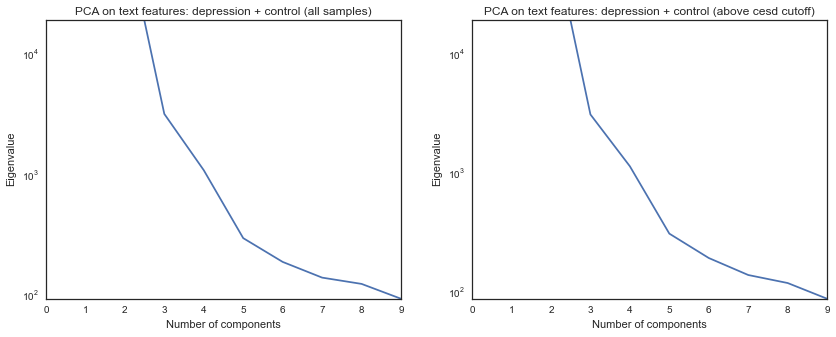

In [589]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
axes[0].plot(sorted(pca_nocesd['latent'], reverse=True)[0:10])
axes[0].set_yscale('log')
axes[0].set_ylim([0,20000])
axes[0].set_title('PCA on text features: {} + control (all samples)'.format(condition))
axes[0].set_xlabel('Number of components')
axes[0].set_ylabel('Eigenvalue')

axes[1].plot(sorted(pca_cesd['latent'], reverse=True)[0:10])
axes[1].set_yscale('log')
axes[1].set_ylim([0,20000])
axes[1].set_title('PCA on text features: {} + control (above {} cutoff)'.format(condition,test_name))
axes[1].set_xlabel('Number of components')
axes[1].set_ylabel('Eigenvalue')
_=plt.show()

### Comparison visualizations: Depression vs control

Separate blocks for all samples, and then above-cesd samples

/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


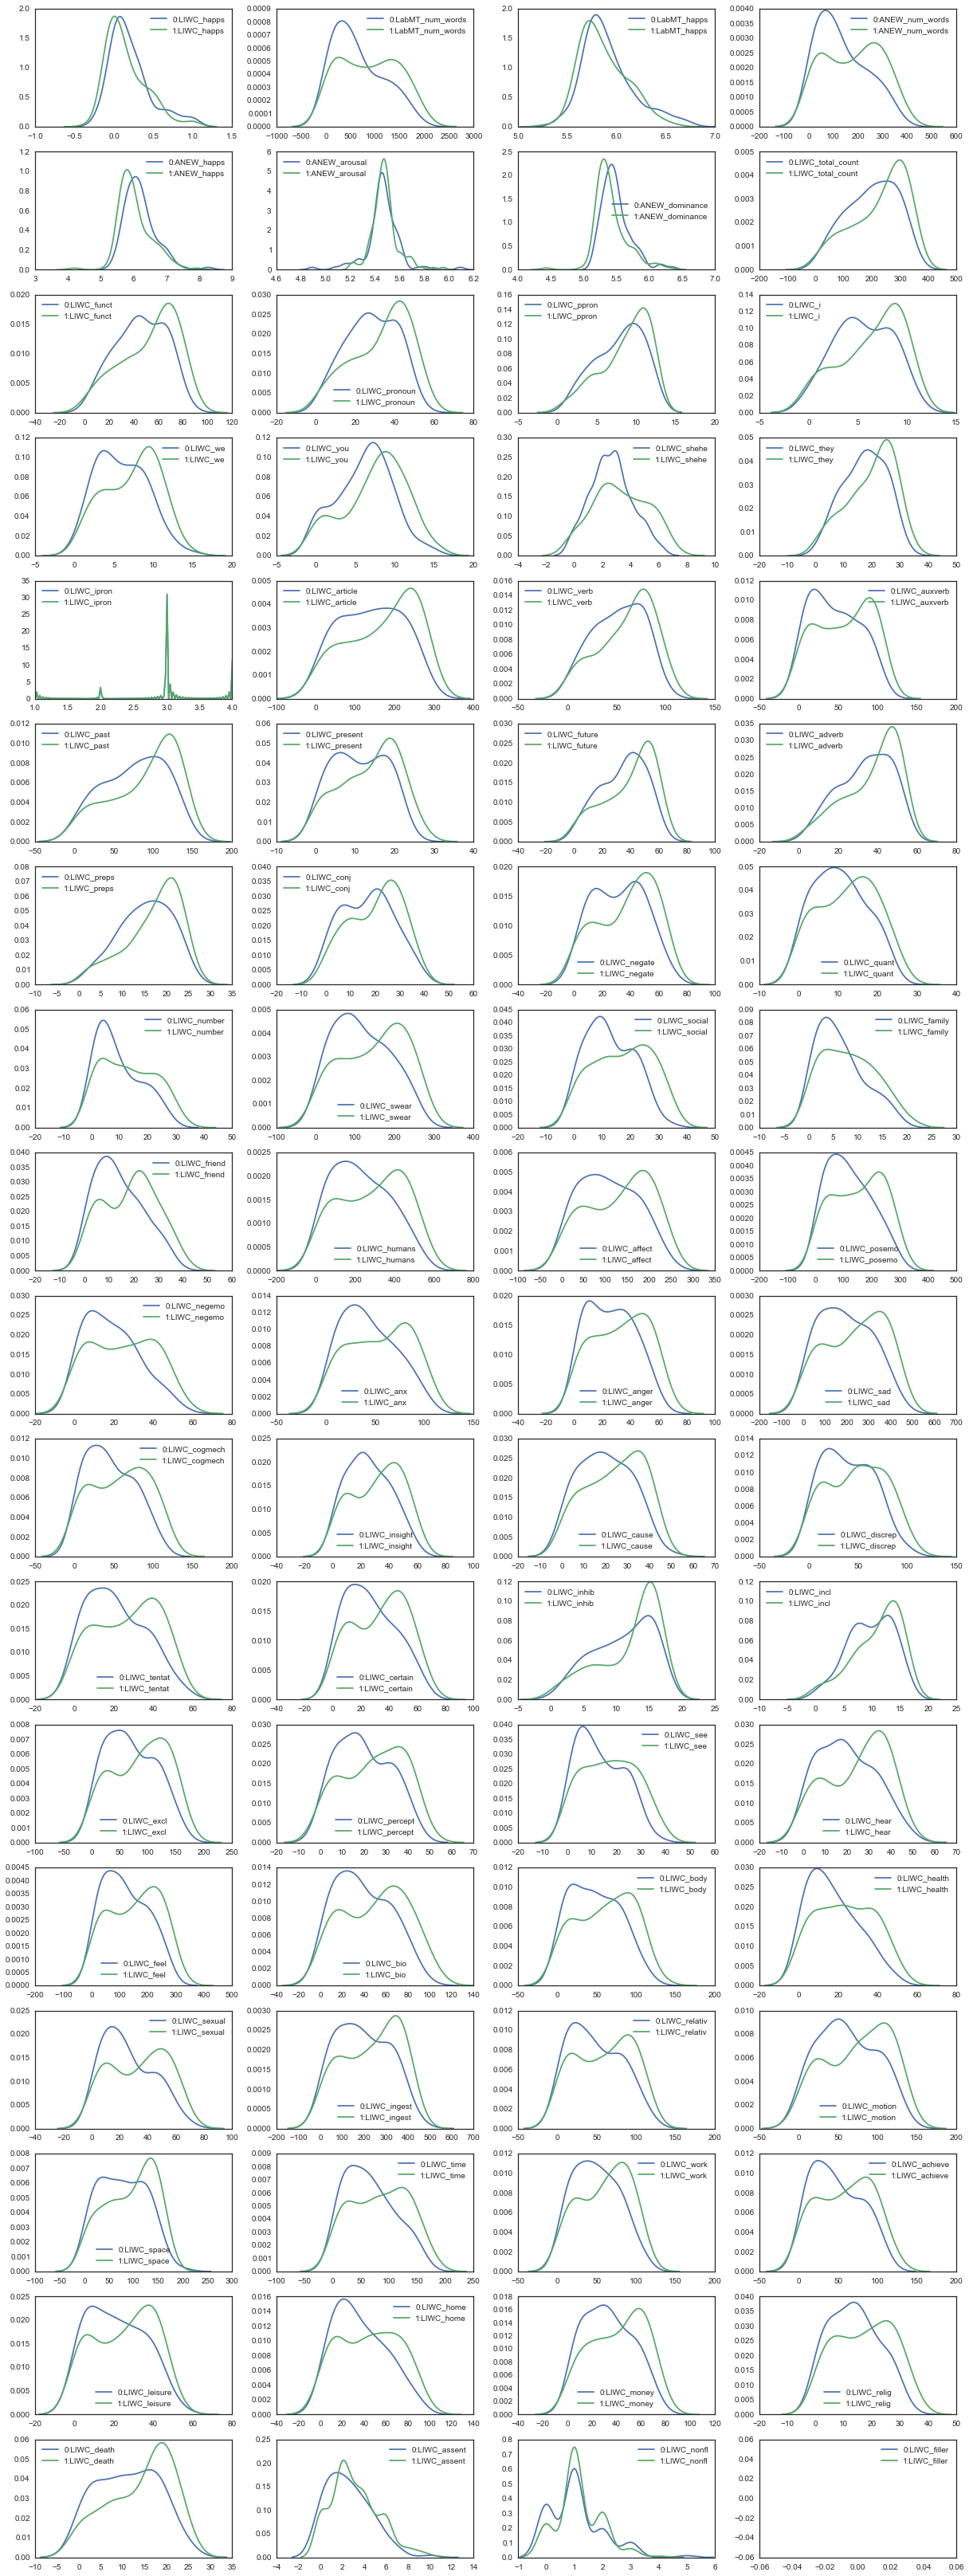

In [590]:
# all samples
gb = tw[new].groupby(condition)

fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(17, 45), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), tw[new].columns[3:-1]):
    for k, v in gb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)

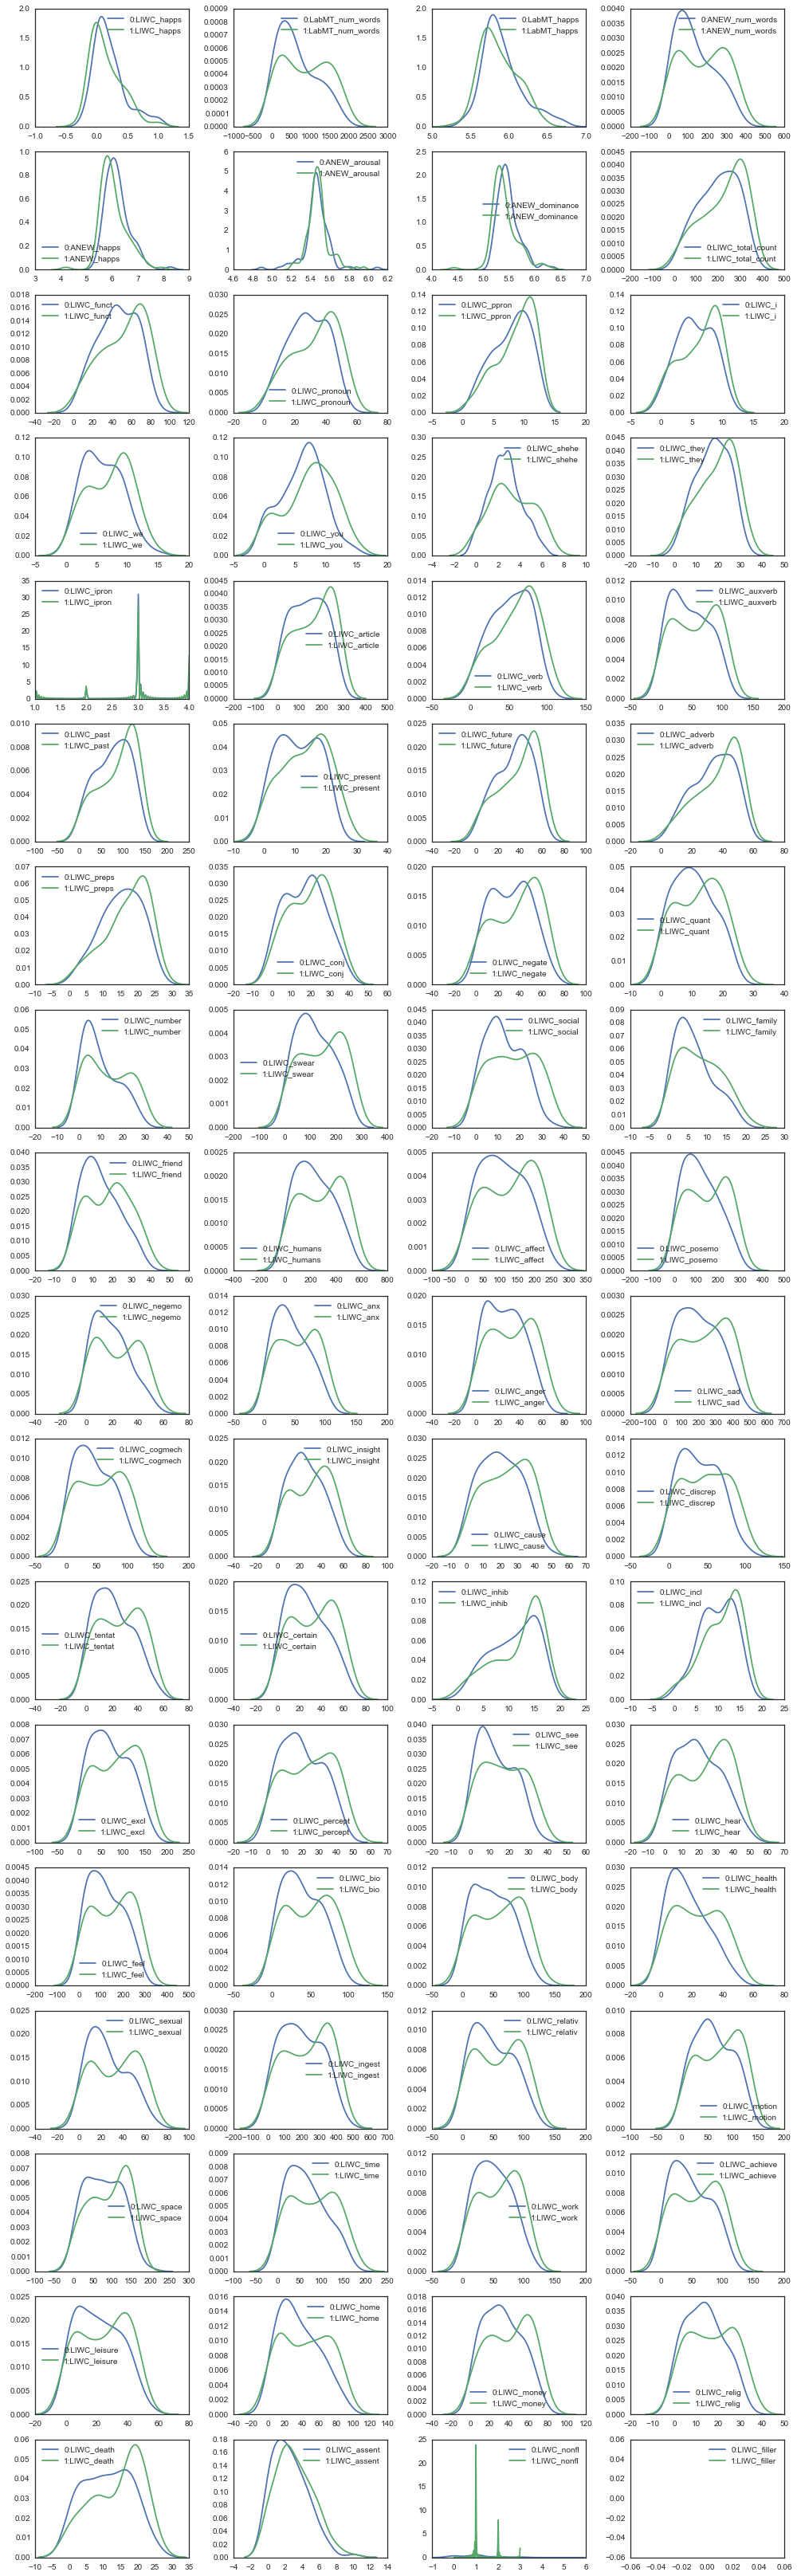

In [618]:
gb = tw['{}_{}_full'.format(old,test_name)].groupby(condition)

fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(14, 45), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), tw['{}_{}_full'.format(old,test_name)].columns[3:-1]):
    for k, v in gb[p]:
        sns.kdeplot(v, ax=ax, label=str(k)+":"+v.name)
        

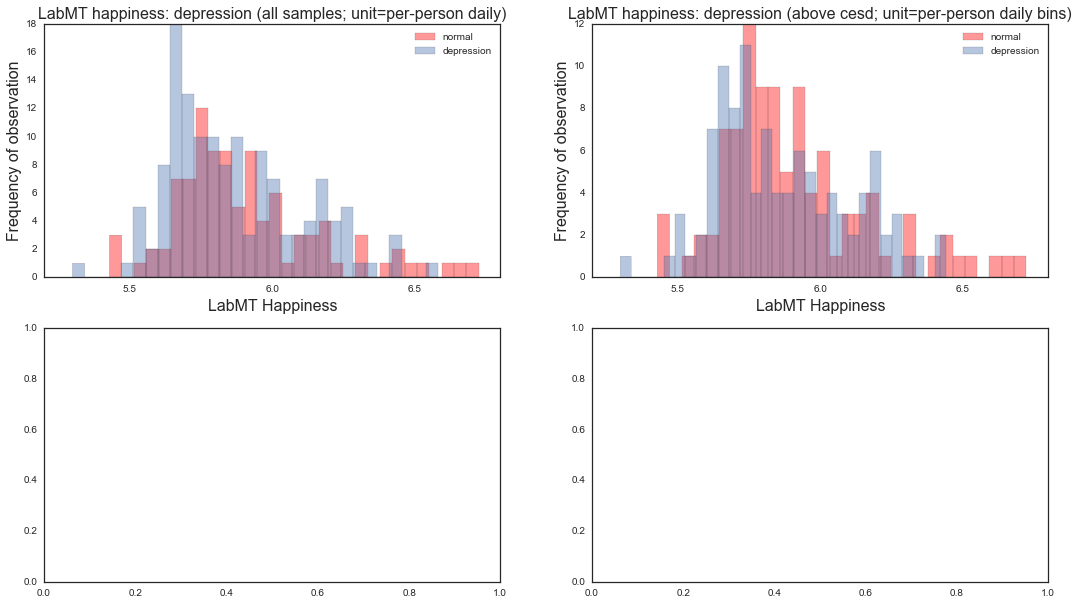

In [594]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,10))

if old == 'daily':
    binsize = 100
elif old == 'indiv':
    binsize = 30
    
axes[0,0].hist(tw[new].ix[tw[new][condition]==0,'LabMT_happs'].values, 
               bins=binsize, alpha=0.4, color='r', label='normal')
axes[0,0].hist(tw[new].ix[tw[new][condition]==1,'LabMT_happs'].values, 
               bins=binsize, alpha=0.4, label=condition)
axes[0,0].set_title('LabMT happiness: {} (all samples; unit=per-person daily)'.format(condition), fontsize=16)
axes[0,0].set_xlabel('LabMT Happiness', fontsize=16)
axes[0,0].set_ylabel('Frequency of observation', fontsize=16)
axes[0,0].legend()

tmpdf = tw['{}_{}_full'.format(old,test_name)] # to improve readability
axes[0,1].hist(tmpdf.ix[tw['{}_{}_full'.format(old,test_name)][condition]==0,'LabMT_happs'].values, 
               bins=binsize, alpha=0.4, color='r', label='normal')
axes[0,1].hist(tmpdf.ix[tw['{}_{}_full'.format(old,test_name)][condition]==1,'LabMT_happs'].values, 
               bins=binsize, alpha=0.4, label=condition)
axes[0,1].set_title('LabMT happiness: {} (above cesd; unit=per-person daily bins)'.format(condition), fontsize=16)
axes[0,1].set_xlabel('LabMT Happiness', fontsize=16)
axes[0,1].set_ylabel('Frequency of observation', fontsize=16)
axes[0,1].legend()

if old == 'daily':
    tmpdf = tw['{}_{}_susp_full'.format(old,test_name)]
    axes[1,0].hist(tmpdf.ix[tmpdf[condition]==0,'LabMT_happs'].values, 
                   bins=binsize, alpha=0.4, color='r', label='normal')
    axes[1,0].hist(tmpdf.ix[tmpdf[condition]==1,'LabMT_happs'].values, 
                   bins=binsize, alpha=0.4, label=condition)
    axes[1,0].set_title('LabMT happiness: {} (above {}, pre-susp; unit=per-person daily bins)'.format(condition,test_name), fontsize=16)
    axes[1,0].set_xlabel('LabMT Happiness', fontsize=16)
    axes[1,0].set_ylabel('Frequency of observation', fontsize=16)
    axes[1,0].legend()

In [595]:
tw[new].columns

Index([u'user_id', u'total_words', u'LIWC_num_words', u'LIWC_happs',
       u'LabMT_num_words', u'LabMT_happs', u'ANEW_num_words', u'ANEW_happs',
       u'ANEW_arousal', u'ANEW_dominance', u'LIWC_total_count', u'LIWC_funct',
       u'LIWC_pronoun', u'LIWC_ppron', u'LIWC_i', u'LIWC_we', u'LIWC_you',
       u'LIWC_shehe', u'LIWC_they', u'LIWC_ipron', u'LIWC_article',
       u'LIWC_verb', u'LIWC_auxverb', u'LIWC_past', u'LIWC_present',
       u'LIWC_future', u'LIWC_adverb', u'LIWC_preps', u'LIWC_conj',
       u'LIWC_negate', u'LIWC_quant', u'LIWC_number', u'LIWC_swear',
       u'LIWC_social', u'LIWC_family', u'LIWC_friend', u'LIWC_humans',
       u'LIWC_affect', u'LIWC_posemo', u'LIWC_negemo', u'LIWC_anx',
       u'LIWC_anger', u'LIWC_sad', u'LIWC_cogmech', u'LIWC_insight',
       u'LIWC_cause', u'LIWC_discrep', u'LIWC_tentat', u'LIWC_certain',
       u'LIWC_inhib', u'LIWC_incl', u'LIWC_excl', u'LIWC_percept', u'LIWC_see',
       u'LIWC_hear', u'LIWC_feel', u'LIWC_bio', u'LIWC_body', u'LI

In [596]:
excluded = [u'user_id',
            u'depression',
            u'no_depression',
            u'time_unit',
            'LIWC_filler']

In [598]:
model_dfs = [{'name':'all {} data'.format(condition),'data':tw[new]}, 
             {'name':'above {} threshold'.format(test_name),'data':tw['{}_{}_full'.format(old,test_name)]}
             ]
if old == 'daily':
    model_dfs.append({'name':'above {} and pre-susp'.format(test_name),'data':tw['{}_{}_susp_full'.format(old,test_name)]})

In [605]:
models = {}

for mdf in model_dfs:
    models[mdf['name']] = {}
    tmp = rf_and_logreg(mdf, excluded, cmat_type='lr')
    models[mdf['name']]['lr'] = tmp[0]
    models[mdf['name']]['rf'] = tmp[1]
    models[mdf['name']]['xtest'] = tmp[2]
    models[mdf['name']]['ytest'] = tmp[3]

MODEL: features predicting depression (all depression data):
ACCURACY: logistic regression: 0.535211267606
ACCURACY: random forests: 0.535211267606

CONFUSION MATRIX (lr):
            pred_norm  pred_cond
known_norm         19         15
known_cond         18         19

Proportion of pred_cond in known_norm: 0.441
Proportion of pred_cond in known_cond: 0.514


MODEL: features predicting depression (above cesd threshold):
ACCURACY: logistic regression: 0.532258064516
ACCURACY: random forests: 0.532258064516

CONFUSION MATRIX (lr):
            pred_norm  pred_cond
known_norm         18         12
known_cond         17         15

Proportion of pred_cond in known_norm: 0.4
Proportion of pred_cond in known_cond: 0.469




In [607]:
cols = tw['{}_{}_full'.format(old,test_name)].columns[~tw['{}_{}_full'.format(old,test_name)].columns.isin(excluded)]
a = pd.DataFrame(models['above {} threshold'.format(test_name)]['rf'].feature_importances_, index=cols, columns=['importance'])



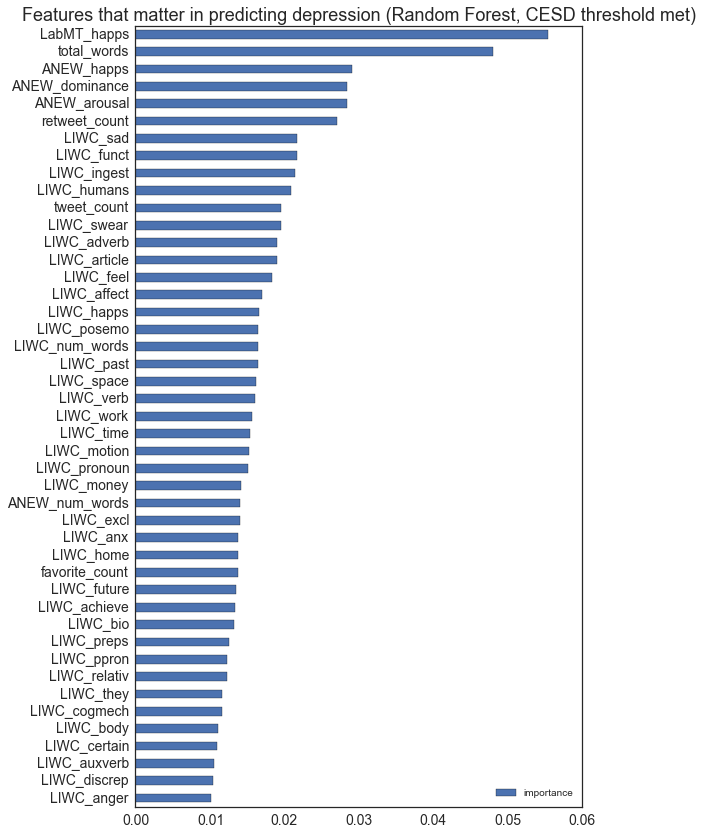

In [262]:
a = pd.DataFrame(models['above {} threshold'.format(test_name)]['rf'].feature_importances_, index=cols, columns=['importance'])

a.sort_values('importance', ascending=True).ix[a.importance > 0.01,:].plot(kind='barh', figsize=(8,14), fontsize=14)
plt.title('Features that matter in predicting depression (Random Forest, CESD threshold met)', fontsize=18)



In [608]:
a.sort_values('importance', ascending=False).ix[a.importance > 0.01,:]


importance
LabMT_happs       0.042239
ANEW_happs        0.037362
LIWC_posemo       0.033154
LIWC_incl         0.029439
LIWC_inhib        0.027666
LIWC_social       0.027331
LIWC_bio          0.025688
ANEW_dominance    0.024918
LIWC_sexual       0.024029
LIWC_anger        0.023732
LIWC_funct        0.023171
LIWC_negate       0.022983
LIWC_health       0.022584
LIWC_hear         0.022321
LIWC_negemo       0.020886
LIWC_happs        0.020621
LIWC_verb         0.020243
LIWC_discrep      0.020053
ANEW_num_words    0.020031
LIWC_leisure      0.019239
LIWC_home         0.019125
retweet_count     0.018676
LIWC_cause        0.018322
LIWC_quant        0.018021
LIWC_auxverb      0.017331
LIWC_space        0.016996
LIWC_pronoun      0.016963
tweet_count       0.016884
favorite_count    0.016455
LIWC_anx          0.015355
total_words       0.015155
LIWC_preps        0.014920
LIWC_friend       0.014249
LIWC_feel         0.013729
LIWC_nonfl        0.013619
LIWC_swear        0.013589
LIWC_num_words    0.012645
LIWC_adverb       0.012222
LIWC_family       0.012008
LIWC_ppron        0.011731
LIWC_motion       0.011573
LIWC_relativ      0.011095
LIWC_money        0.010581

In [506]:
from sklearn.externals import joblib

In [611]:
model_names = ['all {} data'.format(condition),
               'above {} threshold'.format(test_name)]

if old == 'daily':
    model_names.append( 'above {} and pre-susp'.format(test_name) )
    
for name in model_names:
    print 'Confidence vs Coverage for model: {}'.format(name.upper())
    print
    
    
    joblib.dump(models[name]['rf'], 'models/'+'_'.join(['apr16','rf','_'.join(name.split())])+'.pkl')
    X_test = models[name]['xtest']
    y_test = models[name]['ytest']
    
    thresholds = [0.7,0.8,0.9,0.95,0.99]
    preds = pd.DataFrame(models[name]['rf'].predict_proba(X_test), columns=['no','yes'], index=X_test.index)

    for threshold in thresholds:
        a = preds.ix[(preds.no >= threshold) | (preds.yes >= threshold),:].copy()
        if a.shape[0] > 0:
            a['pred'] = 0
            a.ix[a.yes > a.no, 'pred'] = 1

            acc = round(np.sum(a.pred == y_test[a.index]) / float(a.shape[0]), 3)
            print 'accuracy for confidence threshold: {} ='.format(threshold), acc
            print 'coverage:', a.shape[0], 'out of', preds.shape[0], '({}%)'.format(a.shape[0]/float(preds.shape[0]))
            print

            cm_df = pd.DataFrame(confusion_matrix(y_test[a.index],a.pred), 
                                 columns=['pred_no','pred_yes'], 
                                 index=['known_no','known_yes'])
            print cm_df
            print
            print
        else:
            print 'No predictions above this threshold ({})'.format(threshold)
            print 
            print

Confidence vs Coverage for model: ALL DEPRESSION DATA

accuracy for confidence threshold: 0.7 = 0.549
coverage: 51 out of 71 (0.718309859155%)

           pred_no  pred_yes
known_no         7        18
known_yes        5        21


accuracy for confidence threshold: 0.8 = 0.581
coverage: 31 out of 71 (0.43661971831%)

           pred_no  pred_yes
known_no         1        10
known_yes        3        17


accuracy for confidence threshold: 0.9 = 0.5
coverage: 20 out of 71 (0.281690140845%)

           pred_no  pred_yes
known_no         0         9
known_yes        1        10


accuracy for confidence threshold: 0.95 = 0.5
coverage: 6 out of 71 (0.0845070422535%)

           pred_no  pred_yes
known_no         0         2
known_yes        1         3


accuracy for confidence threshold: 0.99 = 0.5
coverage: 6 out of 71 (0.0845070422535%)

           pred_no  pred_yes
known_no         0         2
known_yes        1         3


Confidence vs Coverage for model: ABOVE CESD THRESHOLD

accu

### T-tests

In [624]:
all_usable_features = [u'total_words', u'LIWC_num_words', u'LIWC_happs',
       u'LabMT_num_words', u'LabMT_happs', u'ANEW_num_words', u'ANEW_happs',
       u'ANEW_arousal', u'ANEW_dominance', u'LIWC_total_count', u'LIWC_funct',
       u'LIWC_pronoun', u'LIWC_ppron', u'LIWC_i', u'LIWC_we', u'LIWC_you',
       u'LIWC_shehe', u'LIWC_they', u'LIWC_ipron', u'LIWC_article',
       u'LIWC_verb', u'LIWC_auxverb', u'LIWC_past', u'LIWC_present',
       u'LIWC_future', u'LIWC_adverb', u'LIWC_preps', u'LIWC_conj',
       u'LIWC_negate', u'LIWC_quant', u'LIWC_number', u'LIWC_swear',
       u'LIWC_social', u'LIWC_family', u'LIWC_friend', u'LIWC_humans',
       u'LIWC_affect', u'LIWC_posemo', u'LIWC_negemo', u'LIWC_anx',
       u'LIWC_anger', u'LIWC_sad', u'LIWC_cogmech', u'LIWC_insight',
       u'LIWC_cause', u'LIWC_discrep', u'LIWC_tentat', u'LIWC_certain',
       u'LIWC_inhib', u'LIWC_incl', u'LIWC_excl', u'LIWC_percept', u'LIWC_see',
       u'LIWC_hear', u'LIWC_feel', u'LIWC_bio', u'LIWC_body', u'LIWC_health',
       u'LIWC_sexual', u'LIWC_ingest', u'LIWC_relativ', u'LIWC_motion',
       u'LIWC_space', u'LIWC_time', u'LIWC_work', u'LIWC_achieve',
       u'LIWC_leisure', u'LIWC_home', u'LIWC_money', u'LIWC_relig',
       u'LIWC_death', u'LIWC_assent', u'LIWC_nonfl', u'tweet_count',
       u'retweet_count', u'favorite_count']

In [625]:
features = [u'LIWC_num_words', u'LIWC_social', u'ANEW_arousal', u'ANEW_dominance', u'LIWC_health','tweet_count']
# features = all_usable_features
for mdf in model_dfs:
    print mdf['name'].upper()
    a = mdf['data'].ix[mdf['data'][condition]==0,:]
    b = mdf['data'].ix[mdf['data'][condition]==1,:]
    
    ttest_output(a,b,features, correction='b')
    print
    print

ALL DEPRESSION DATA
RATING: LIWC_num_words
Ttest_indResult(statistic=-3.456885344309975, pvalue=0.00064891234643323569)

RATING: LIWC_social
Ttest_indResult(statistic=-3.6583464097817346, pvalue=0.00031364241151945788)

RATING: ANEW_arousal
Ttest_indResult(statistic=-1.0763804980515257, pvalue=0.28286560730935451)

RATING: ANEW_dominance
Ttest_indResult(statistic=2.5819623253395028, pvalue=0.010433535664214153)

RATING: LIWC_health
Ttest_indResult(statistic=-3.4681527887521337, pvalue=0.00062358517235469558)

RATING: tweet_count
Ttest_indResult(statistic=-2.3529347261985554, pvalue=0.019454782833513526)

bonferroni-corrected alpha of 0.05: 0.00833333333333
LIWC_num_words significant post-correction? True (0.0038934740786)
LIWC_social significant post-correction? True (0.00188185446912)
ANEW_arousal significant post-correction? False (1.0)
ANEW_dominance significant post-correction? False (0.0626012139853)
LIWC_health significant post-correction? True (0.00374151103413)
tweet_count sign

### Now check whether a) post-diag depr tweets are different (at indiv level) than controls, and b) whether daily-level analysis ends up having correct predictions bunched around just a few users (meaning, only a few very depressed high-frequency tweeters are driving the effect)